<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Import packages</h1>

In [1]:
import easydict
import os
import numpy as np
import math
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision

import pandas as pd
from tqdm import tqdm 
import time

from random import randint
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML
from matplotlib import rc
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
%matplotlib inline

import copy as cp
from IPython.display import clear_output

# use_cuda = True
use_cuda = False
if torch.cuda.is_available():
  device = torch.device("cuda")

In [2]:
os.makedirs("images", exist_ok=True)
arg = easydict.EasyDict({ "n_epochs": 20, 
                          "batch_size": 64, 
                          "lr": 1e-3, 
                          "b1": 0.9,
                          "b2": 0.999,
                          "weight_decay": 0.0001,
                          "input_dim": 40,
                          "output_dim": 40,
                          "hidden_dim": [64,128],
                          "goal_dim": 6,
                          "n_cpu": 8,
                          "re_size": 40,
                          "sample_interval": 400 })
print(arg)

cuda = True if torch.cuda.is_available() else False
cuda=False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
CodePath = os.getcwd()


{'n_epochs': 20, 'batch_size': 64, 'lr': 0.001, 'b1': 0.9, 'b2': 0.999, 'weight_decay': 0.0001, 'input_dim': 40, 'output_dim': 40, 'hidden_dim': [64, 128], 'goal_dim': 6, 'n_cpu': 8, 're_size': 40, 'sample_interval': 400}


<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Data organization</h1>

In [3]:
# Load data
Quad_data = torch.tensor(np.load(CodePath+'/data/Quad_data.npy'))
PathsData = torch.tensor(np.load(CodePath+'/data/Paths.npy'))

NUMval = 2000
Paths = cp.deepcopy(PathsData[NUMval:,:,:])
Paths_test = cp.deepcopy(PathsData[:NUMval,:,:])
Paths_ori = cp.deepcopy(Paths)
Paths_test_ori = cp.deepcopy(Paths_test)

MaxPathNum = np.shape(Paths)[0]
MaxSampleNum = np.shape(Paths)[1]
Path_dim = np.shape(Paths)[2]

In [4]:
# Place data into dataloader
class GenDataset(Dataset):
 
  def __init__(self, PathData, transform=None):
      self.data = PathData[:,:-1,:].float()
      self.target = PathData[:,1:,:].float()
      self.transform = transform
      
  def __getitem__(self, index):
      input = self.data[index]
      output = self.target[index]
      if self.transform:
            input = self.transform(input)
            output = self.transform(output)

      return index, input, output
 
  def __len__(self):
      return len(self.data)

transform = transforms.Compose(
    [
     transforms.ToPILImage(),
    #  transforms.Scale(size=(arg.re_size, arg.re_size)),
     transforms.ToTensor(),
    #  transforms.Normalize(mean=[0.5], std=[0.5])
    ])

NameSpace = {0:'baseX', 1:'baseY', 2:'baseZ'}
Scaler = 100.0
zDomain=[-26,-23,-20,-17,-14,-11,-8,-5]
Paths[:,:,-16:-4] = Paths_ori[:,:,-16:-4]/Scaler
Paths_test[:,:,-16:-4] = Paths_test_ori[:,:,-16:-4]/Scaler
path_dataset = GenDataset(Paths, transform=None)
path_data_loader = DataLoader(path_dataset,batch_size=arg.batch_size,shuffle=True)

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Network definition</h1>

In [5]:
def GenHnC(batch_size=arg.batch_size, requires_grad=True):
    hidden_dim=arg.hidden_dim
    HnC=[]
    for idx in range(len(hidden_dim)):
        hidden=torch.zeros(1, batch_size, hidden_dim[idx], requires_grad=requires_grad).type(Tensor)
        cell=torch.zeros(1, batch_size, hidden_dim[idx], requires_grad=requires_grad).type(Tensor) 
        HnC.append((hidden,cell))
    return HnC

class swish(nn.Module): 
  def __init__(self): 
    super(swish, self).__init__()

  def forward(self, X):
    return X * torch.sigmoid(X) 

class mish(nn.Module): 
  def __init__(self): 
    super(mish, self).__init__()

  def forward(self, X):
    return X * torch.tanh(F.softplus(X))

class DeepQMP(nn.Module): # torch.nn.Module을 상속받는 파이썬 클래스
    def __init__(self): 
        super(DeepQMP, self).__init__()
        input_dim=arg.input_dim
        hidden_dim=arg.hidden_dim
        output_dim=arg.output_dim
        goal_dim=arg.goal_dim

        input_dim=arg.input_dim + arg.goal_dim
        hidden_dim=arg.hidden_dim

        alpha=0.01

        # CNN
        ch1 = 24
        ch2 = 36
        self.Conv = nn.Sequential(
                                              nn.Conv2d(1, ch1, (3, 1), stride=(3,1)),
                                              nn.BatchNorm2d(ch1, 0.8),
                                              # nn.LeakyReLU(alpha, inplace=True),
                                              mish(),
                                  
                                              nn.Conv2d(ch1, ch2, (14, 1), stride=1),
                                              nn.BatchNorm2d(ch2, 0.8),
                                              # nn.LeakyReLU(alpha, inplace=True),
                                              mish(),
                                  )
        CnnDim = 1
        sub_input_dim = CnnDim * ch2 + 4

        # LSTM
        self.lstm1 = nn.LSTM(sub_input_dim, hidden_dim[0], bias=True)   
        self.lstm2 = nn.LSTM(hidden_dim[0], hidden_dim[1], bias=True)    
        
        dslayer1 = 512  
        dslayer2 = 256
        dslayer3 = 128  
        dslayer4 = 64
        dslayer5 = 46  
        self.LSTM_DenseNet = nn.Sequential(
                                                nn.Linear(hidden_dim[1], dslayer1, bias=True),
                                                nn.BatchNorm1d(dslayer1, 0.8),
                                                # nn.LeakyReLU(alpha, inplace=True),
                                                mish(),
                                           
                                                nn.Linear(dslayer1, dslayer2, bias=True),     
                                                nn.BatchNorm1d(dslayer2, 0.8),
                                                # nn.LeakyReLU(alpha, inplace=True),
                                                mish(),
                                           
                                                nn.Linear(dslayer2, dslayer3, bias=True),   
                                                nn.BatchNorm1d(dslayer3, 0.8),
                                                # nn.LeakyReLU(alpha, inplace=True),
                                                mish(),
                                           
                                                nn.Linear(dslayer3, dslayer4, bias=True),   
                                                nn.BatchNorm1d(dslayer4, 0.8),
                                                # nn.LeakyReLU(alpha, inplace=True),
                                                mish(),
                                           
                                                nn.Linear(dslayer4, dslayer5, bias=True),   
                                                nn.BatchNorm1d(dslayer5, 0.8),
                                                # nn.LeakyReLU(alpha, inplace=True),
                                                mish(),
                                           
                                                nn.Linear(dslayer5, output_dim, bias=True),
                                            )
        
        # MLP
        nnlayer1 = 1024
        nnlayer2 = 512
        nnlayer3 = 256
        nnlayer4 = 128
        nnlayer5 = 64
        self.MLP_DenseNet = nn.Sequential(
                                                nn.Linear(sub_input_dim, nnlayer1, bias=True),
                                                nn.BatchNorm1d(nnlayer1, 0.8),
                                                # nn.LeakyReLU(alpha, inplace=True),
                                                mish(),
                                          
                                                nn.Linear(nnlayer1, nnlayer2, bias=True),
                                                nn.BatchNorm1d(nnlayer2, 0.8),
                                                # nn.LeakyReLU(alpha, inplace=True),
                                                mish(),
                                          
                                                nn.Linear(nnlayer2, nnlayer3, bias=True),
                                                nn.BatchNorm1d(nnlayer3, 0.8),
                                                # nn.LeakyReLU(alpha, inplace=True),
                                                mish(),
                                          
                                                nn.Linear(nnlayer3, nnlayer4, bias=True),
                                                nn.BatchNorm1d(nnlayer4, 0.8),
                                                # nn.LeakyReLU(alpha, inplace=True),
                                                mish(),
                                          
                                                nn.Linear(nnlayer4, nnlayer5, bias=True),
                                                nn.BatchNorm1d(nnlayer5, 0.8),
                                                # nn.LeakyReLU(alpha, inplace=True),
                                                mish(),
                                          
                                                nn.Linear(nnlayer5, output_dim, bias=True),
                                          
                                            )

        self.End = nn.Sequential(
                                              nn.Linear(output_dim*2, output_dim, bias=False),
                                          )

    def forward(self, X, HnC):
        # HnC : Hiddne and Cell state
        # X     = (seq, batch, dim)
        # CnnX  = (batch, ch, dim, seq)
        # lstmX = (seq, batch, dim)
        # mlpX  = (batch, dim)

        # CNN
        CnnX = torch.cat([X[:,:,:-10], X[:,:,-6:]], dim=2)
        CnnX = CnnX.reshape(CnnX.shape[1], 1, CnnX.shape[2], CnnX.shape[0])
        cnn_out = self.Conv(CnnX)
        CONVoutput = cnn_out.permute(3,0,1,2) #(seq, batch, ch, dim)
        
        # LSTM
        lstmX = CONVoutput.reshape(cnn_out.shape[3], cnn_out.shape[0], -1) #(seq, batch, dim*ch)
        lstmX = torch.cat([lstmX, X[:,:,-10:-6]], dim=2) + X[-1,:,:-6]
        lstm_out1, nHnC1 = self.lstm1(lstmX, HnC[0])
        lstm_out2, nHnC2 = self.lstm2(lstm_out1, HnC[1])
        LSTMoutput = self.LSTM_DenseNet(lstm_out2[-1])
        LSTMoutput[:,-4:] = torch.sigmoid(LSTMoutput[:,-4:])
        newHnC = [nHnC1, nHnC2]
        
        # MLP
        mlpX = lstmX[-1,:,:].view(lstmX.shape[1],lstmX.shape[2]) #(batch, dim*ch)
        # mlpX = X[-1,:,:].view(X.shape[1],X.shape[2])
        NNoutput = self.MLP_DenseNet(mlpX)
        NNoutput[:,-4:] = torch.sigmoid(NNoutput[:,-4:])

        # Residual connection
        # inputA = (LSTMoutput + X[-1,:,:-6]).view(-1,arg.output_dim)
        # inputB = (NNoutput + X[-1,:,:-6]).view(-1,arg.output_dim)
        inputA = (LSTMoutput + mlpX).view(-1,arg.output_dim)
        inputB = (NNoutput + mlpX).view(-1,arg.output_dim)

        output_ = self.End(torch.cat([inputA, inputB],dim=1))
        output_[:,-4:] = torch.sigmoid(output_[:,-4:])
        # output_ = LSTMoutput
        # output_ = NNoutput

        return output_, newHnC
  

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Training sequence</h1>

In [24]:
# Network model
Estimator = DeepQMP()
if cuda:
    Estimator.cuda()

# optimizer
optimizer = torch.optim.AdamW(Estimator.parameters(), lr=arg.lr, betas=(arg.b1, arg.b2), weight_decay=arg.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 500)
# optimizer = torch.optim.Adam(Estimator.parameters(), lr=arg.lr, betas=(arg.b1, arg.b2))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience= 10,mode='min')

In [100]:
# Loss
L1_loss = nn.L1Loss()
L2_loss = nn.MSELoss()
Huber_loss = nn.SmoothL1Loss()
BCE_Loss = torch.nn.BCELoss()

def L1_regularization(model):
  regularization_loss=0
  for param in model.parameters():
    regularization_loss += torch.sum(torch.abs(param))
    
  return regularization_loss
 
def L2_regularization(model):
  regularization_loss=0
  for param in model.parameters():
    regularization_loss += param.norm(2)**2
    
  return regularization_loss

def cutoff(X):
    return torch.tensor(X>0.5, dtype=torch.float)

def LossPlot(train_loss, bce_loss, reg_loss):
    fig = plt.figure()
    fig.suptitle("Train loss : "+str(train_loss[-1]))
    offset = 50
    
    ax1 = host_subplot(111, axes_class=AA.Axes)
    bceloss,=ax1.plot(bce_loss, color='g', label='BCE loss')
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("Binary Cross Entropy")
    ax1.yaxis.label.set_color('g')
    
    ax2 = ax1.twinx()
    new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
    ax2.axis["right"] = new_fixed_axis(loc="right", axes=ax2, offset=(0, 0))
    loss,=ax2.plot(train_loss, color='b', label='Train loss')
    ax2.set_xlabel("Steps")
    ax2.set_ylabel("Losses")
    ax2.yaxis.label.set_color('b')
    
    ax3 = ax1.twinx()
    new_fixed_axis = ax3.get_grid_helper().new_fixed_axis
    ax3.axis["right"] = new_fixed_axis(loc="right", axes=ax3, offset=(offset, 0))
    regloss,=ax3.plot(reg_loss, color='r', label='Regularazation loss')
    ax3.set_xlabel("Steps")
    ax3.set_ylabel("Regularization")
    ax3.yaxis.label.set_color('r')

    graphs=[bceloss, loss, regloss]
    ax3.legend(graphs, [curve.get_label() for curve in graphs])
    plt.show()
    fig.tight_layout()
    fig.savefig(CodePath+'/graph/LearningLoss.png',dpi=80)

# SampleDist = abs(Paths[:,:-1,:-4]-Paths[:,1:,:-4]).mean()
def Convergence_Loss(Predict, Origin, Target): 
#     optDist = abs(Origin[:,:-4]-Target[:,:-4]).mean(1)   
    alpha = 1
    lambdaExp = 1.
    lambdaIN = 1
    lambdaDIST = 0
    lambdaBCE = 0.05
    lambdaReg = 0.001
            
#     Lin   = L2_loss(Predict[:,:-4], Origin[:,:-4])
#     LdistIN=torch.square(Predict[:,:-4]-Origin[:,:-4])
#     LdistEXP=torch.square(Predict[:,:-4]-Target[:,:-4])
#     Ldist = abs(optDist-(LdistIN+LdistEXP).mean(1)).mean()
    Lexp  = L2_loss(Predict[:,:-4], Target[:,:-4])
    Lbce  = BCE_Loss(Predict[:,-4:], Target[:,-4:])
    Lreg  = L2_regularization(Estimator)/(2*Predict.shape[1])

#     print('Lin   : ',Lin)
    print('Lexp  : ',Lexp)
#     print('Ldist : ',Ldist)
    print('Lbce  : ',Lbce)
    print('Lreg  : ',Lreg)

    # return lambdaExp*Lexp + Lexp/(alpha+lambdaIN*Lin) + lambdaBCE*Lbce + lambdaReg*Lreg
    return lambdaExp*Lexp + lambdaBCE*Lbce + lambdaReg*Lreg
    # return lambdaExp*Lexp + lambdaDIST*Ldist + lambdaBCE*Lbce + lambdaReg*Lreg
    # return lambdaExp*Lexp + lambdaBCE*Lbce + lambdaReg*Lreg
    # return lambdaExp*Lexp + + lambdaReg*Lreg
    # return (lambdaExp*Lexp + Lexp/(alpha+lambdaIN*Lin)).float()
    # return Lexp

In [341]:
# Load CHECK POINT
params = torch.load(CodePath+"/model/DeepQMP.tar", map_location = "cpu")
Estimator.load_state_dict(params['model_state_dict'])

<All keys matched successfully>

In [ ]:
# Learning loop 
Estimator.train()

hypothesis=[]
prediction=[]

train_loss=[]
reg_loss=[]
bce_loss=[]

for epoch in tqdm(range(arg.n_epochs), position=0, leave=True):
    for batch_idx, pathData in enumerate(path_data_loader):
      # Learn for various sequence size
      Xtr = Variable(np.transpose(pathData[1].view(pathData[0].shape[0], -1, Path_dim),(1,0,2)).type(Tensor))
      Ytr = Variable(np.transpose(pathData[2].view(pathData[0].shape[0], -1, Path_dim),(1,0,2)).type(Tensor))
      # seq_size = randint(1,MaxSampleNum-1)
      # MaxSeq=10
      # seq_size = randint(1,MaxSeq)
      seq_size = 1
      SRT=0
      # SRT=randint(0,MaxSampleNum-seq_size-1)
      END=SRT+seq_size
      if END > MaxSampleNum-1:
                END = MaxSampleNum-1

      sub_batch=0
      sub_batch_NUM = (MaxSampleNum-END)//(END-SRT)
      HnC = GenHnC(pathData[0].shape[0])
      while SRT < MaxSampleNum-1: 
        # Clear ipython output
        clear_output(wait=True)

        Xsample = Xtr[SRT:END,:,:].view(END-SRT, -1, Path_dim)
        Ysample = Ytr[SRT:END,:,:].view(END-SRT, -1, Path_dim)
        States = Xsample.view(Xsample.shape[0],-1,Path_dim)
        Goals = Ytr[-1,:,0:6].view(1,-1,6).repeat(Xsample.shape[0], 1, 1)
        Xdata = torch.cat([States, Goals],dim=2)

#         HnC = GenHnC(pathData[0].shape[0])
        hypothesis,_ = Estimator(Xdata, HnC) # Xdata : (seq, batch, dim), concated with goal
        Predict = hypothesis#.data#.cpu()
        Origin = Xsample[-1]#.data#.cpu()
        Target = Ysample[-1]#.data#.cpu()
        trloss = Convergence_Loss(Predict,Origin,Target)

        # Optimize
        optimizer.zero_grad()
        trloss.backward()
        optimizer.step()
        scheduler.step()
        # scheduler.step(trloss)

        print(
              "[Epoch %d/%d] [Batch %d/%d] [Sub Batch %d/%d] [seq_size: %f] [loss: %f]"
              % (epoch, arg.n_epochs, batch_idx % len(path_data_loader), len(path_data_loader), sub_batch, sub_batch_NUM, seq_size, trloss.item())
          )
        sub_batch=sub_batch+1
        
        SRT = END
        END = END+seq_size
        if END > MaxSampleNum-1:
          END = MaxSampleNum-1
          sub_batch=0
          sub_batch_NUM = (MaxSampleNum-END)//(END-SRT+1)

      # Plot and Save losses
      if batch_idx%10 == 0:
        # Save train loss
        train_loss.append(trloss.item())
        reg_loss.append((L2_regularization(Estimator)/(2*Predict.shape[0])).item())
        bce_loss.append((BCE_Loss((hypothesis[:,-4:]), Ysample[-1,:,-4:])).item())

        LossPlot(train_loss, bce_loss, reg_loss)

      #   idx = randint(0,arg.batch_size-1)
      #   num_sam = 50
      #   plt.scatter(Xsample[:,0:num_sam,0].cpu(), Xsample[:,0:num_sam,1].cpu(),s=120.0, c='yellow', edgecolors='black', label='Start')
      #   plt.scatter(Ysample[-1,0:num_sam,0].cpu(), Ysample[-1,0:num_sam,1].cpu(),s=120.0 , c='red', edgecolors='black', label='Final')
      #   plt.scatter(Ytr[-1,0:num_sam,0].cpu(), Ytr[-1,0:num_sam,1].cpu(),s=50.0 , c='grey', edgecolors='black', label='Goals')
      #   plt.scatter(hypothesis[0:num_sam,0].cpu().detach().numpy(), hypothesis[0:num_sam,1].cpu().detach().numpy(),s=120.0 , c='lime', edgecolors='black', alpha=0.8, label='Predict')
      #   plt.legend(fontsize='x-large')
      #   plt.show()

      # Save checkpoint
      torch.save({'model_state_dict': Estimator.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': trloss},
                  CodePath+"/model/DeepQMP.tar", pickle_protocol = 4)

      # del pathData
      # torch.cuda.empty_cache()
      

print("Final loss : ",trloss.data.item())
t=time.localtime(time.time())
plt.title("Train loss : "+str(trloss.cpu().detach().numpy()))
plt.plot(train_loss)
plt.savefig(CodePath+'/graph/LearningLoss_'+str(t.tm_year)+str(t.tm_mon)+str(t.tm_mday)+str(t.tm_hour)+str(t.tm_min)+'.png',dpi=100)
# plt.show()
 
# Save model & parameters
torch.save({'model_state_dict': Estimator.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': trloss},
            CodePath+"/model/DeepQMP"+str(t.tm_year)+str(t.tm_mon)+str(t.tm_mday)+str(t.tm_hour)+str(t.tm_min)+".tar", pickle_protocol = 4)

  0%|          | 0/20 [17:42:53<?, ?it/s]

Lexp  :  tensor(0.0081, grad_fn=<MseLossBackward>)
Lbce  :  tensor(0.0160, grad_fn=<BinaryCrossEntropyBackward>)
Lreg  :  tensor(2.4390, grad_fn=<DivBackward0>)


KeyboardInterrupt: 

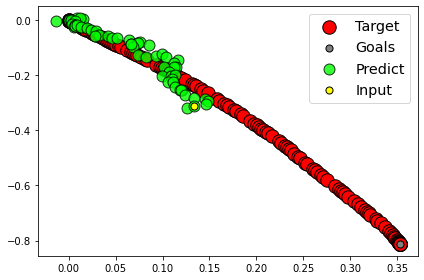

In [342]:
# Learning recursive planning 
Estimator.train()

hypothesis=[]
prediction=[]

train_loss=[]
reg_loss=[]
bce_loss=[]
cnt=0

for epoch in tqdm(range(arg.n_epochs), position=0, leave=True):
    for batch_idx, pathData in enumerate(path_data_loader):
        # Learn for various sequence size
        Xtr = Variable(np.transpose(pathData[1].view(pathData[0].shape[0], -1, Path_dim),(1,0,2)).type(Tensor))
        Ytr = Variable(np.transpose(pathData[2].view(pathData[0].shape[0], -1, Path_dim),(1,0,2)).type(Tensor))
        seq_size = 1
        SRT=0
        END=SRT+seq_size
        if END > MaxSampleNum-1:
                END = MaxSampleNum-1

        States = Xtr[0,:,:].view(1,-1,Path_dim)
        Goals = Ytr[-1,:,0:6].view(1,-1,6)
        HnC = GenHnC(pathData[0].shape[0])
        Path = States
        while SRT < MaxSampleNum-1: 
            # Clear ipython output
            clear_output(wait=True)
            
            Xdata = torch.cat([States, Goals],dim=2)
            StatesNew,HnCnew = Estimator(Xdata, HnC) # Xdata : (seq, batch, dim), concated with goal
            
            # Calculate contact
#             StatesNew[:,-4:] = cutoff(StatesNew[:,-4:])
            # Revise negative forces
#             for dom in zDomain:
#                 StatesNew[:,dom] = torch.tensor(~(StatesNew[:,dom]<0), dtype=torch.float)*StatesNew[:,dom]

#             StatesNew[:,-26] = torch.tensor(~(StatesNew[:,-4] == 1), dtype=torch.float)*StatesNew[:,-26]
#             StatesNew[:,-14] = torch.tensor((StatesNew[:,-4] == 1), dtype=torch.float)*StatesNew[:,-14]
            
#             StatesNew[:,-23] = torch.tensor(~(StatesNew[:,-3] == 1), dtype=torch.float)*StatesNew[:,-23]
#             StatesNew[:,-11] = torch.tensor((StatesNew[:,-3] == 1), dtype=torch.float)*StatesNew[:,-11]
            
#             StatesNew[:,-20] = torch.tensor(~(StatesNew[:,-2] == 1), dtype=torch.float)*StatesNew[:,-20]
#             StatesNew[:,-8] = torch.tensor((StatesNew[:,-2] == 1), dtype=torch.float)*StatesNew[:,-8]
            
#             StatesNew[:,-17] = torch.tensor(~(StatesNew[:,-1] == 1), dtype=torch.float)*StatesNew[:,-17]
#             StatesNew[:,-5] = torch.tensor((StatesNew[:,-1] == 1), dtype=torch.float)*StatesNew[:,-5]
            
            Predict = StatesNew
            Origin = Xtr[SRT:END,:,:].view(-1, Path_dim)
            Target = Ytr[SRT:END,:,:].view(-1, Path_dim)
            trloss = Convergence_Loss(Predict,Origin,Target)
            
            # Optimize
            optimizer.zero_grad()
            trloss.backward()
            optimizer.step()
            scheduler.step()
            
            print(
                  "[Epoch %d/%d] [Batch %d/%d] [seq_size: %f] [cnt: %f] [loss: %f]"
                  % (epoch, arg.n_epochs, batch_idx % len(path_data_loader), len(path_data_loader), seq_size, cnt, trloss.item())
              )

            # Save checkpoint
            torch.save({'model_state_dict': Estimator.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'loss': trloss},
                      CodePath+"/model/DeepQMP.tar", pickle_protocol = 4)
            
            # Update rule
            if( trloss.item() < 0.01):
#                 HnC = HnCnew
                States = Variable(StatesNew.data)
                States = States.view(1,-1,Path_dim)
                Path = torch.cat([Path.view(-1,pathData[0].shape[0],Path_dim), States.view(1,pathData[0].shape[0],Path_dim)], dim=0)
                SRT = SRT+1
                END = END+1
                if END > MaxSampleNum:
                    END = MaxSampleNum
                    
                # Plot and Save losses
                if cnt%10 == 0:
                    # Save train loss
                    train_loss.append(trloss.item())
                    reg_loss.append((L2_regularization(Estimator)/(2*Predict.shape[0])).item())
                    bce_loss.append((BCE_Loss((Predict[:,-4:]), Target[:,-4:])).item())

                    LossPlot(train_loss, bce_loss, reg_loss)

                    num_sam = 1
                    fig = plt.figure()
                    plt.scatter(Ytr[:,0:num_sam,0].cpu(), Ytr[:,0:num_sam,1].cpu(),s=180.0 , c='red', edgecolors='black', label='Target')
                    plt.scatter(Ytr[-1,0:num_sam,0].cpu(), Ytr[-1,0:num_sam,1].cpu(),s=50.0 , c='grey', edgecolors='black', label='Goals')
                    plt.scatter(Path[:,0:num_sam,0].cpu().detach().numpy(), Path[:,0:num_sam,1].cpu().detach().numpy(),s=120.0 , c='lime', edgecolors='black', alpha=0.8, label='Predict')
                    plt.scatter(States[0,0:num_sam,0].cpu(), States[0,0:num_sam,1].cpu(),s=50.0, c='yellow', edgecolors='black', label='Input')
                    plt.legend(fontsize='x-large')
                    plt.draw()
                    fig.tight_layout()
                    fig.savefig(CodePath+'/graph/Path.png',dpi=80)

                cnt = cnt+1
                
            # del pathData
            # torch.cuda.empty_cache()
      
print("Final loss : ",trloss.data.item())
t=time.localtime(time.time())
plt.title("Train loss : "+str(trloss.cpu().detach().numpy()))
plt.plot(train_loss)
plt.savefig(CodePath+'/graph/LearningLoss_'+str(t.tm_year)+str(t.tm_mon)+str(t.tm_mday)+str(t.tm_hour)+str(t.tm_min)+'.png',dpi=100)
# plt.show()
 
# Save model & parameters
torch.save({'model_state_dict': Estimator.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': trloss},
            CodePath+"/model/DeepQMP"+str(t.tm_year)+str(t.tm_mon)+str(t.tm_mday)+str(t.tm_hour)+str(t.tm_min)+".tar", pickle_protocol = 4)

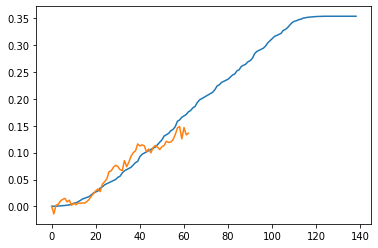

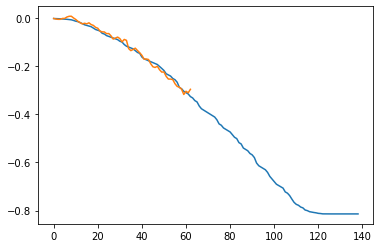

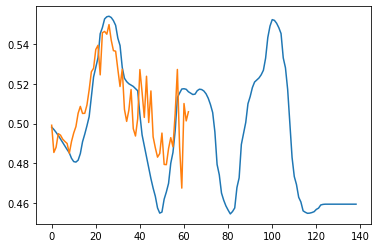

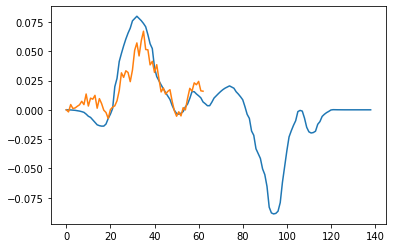

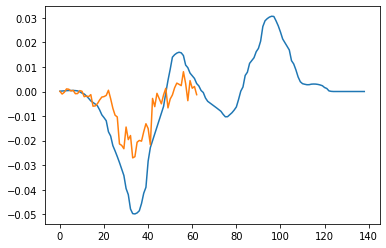

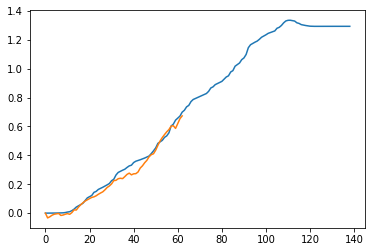

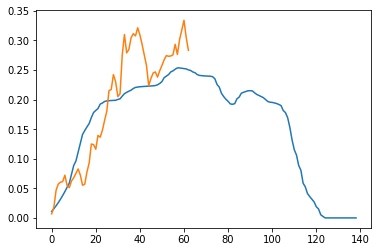

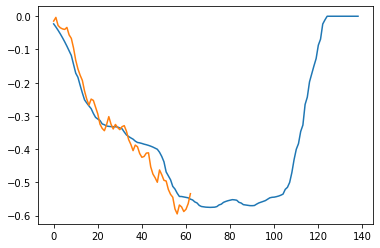

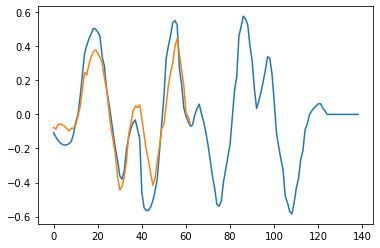

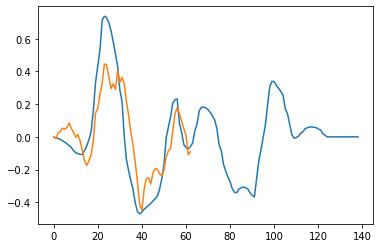

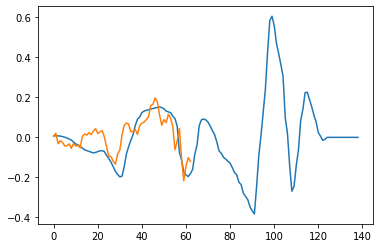

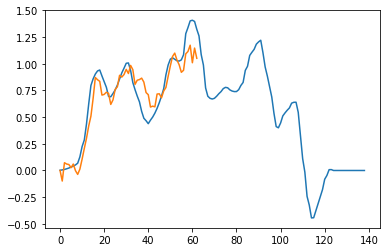

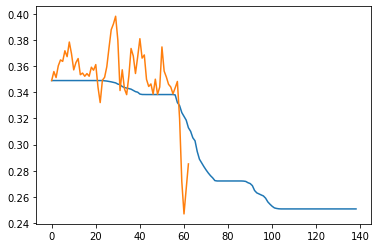

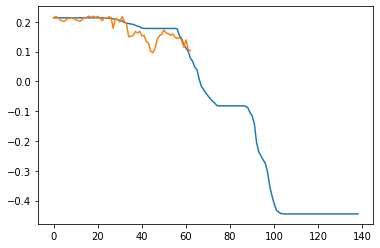

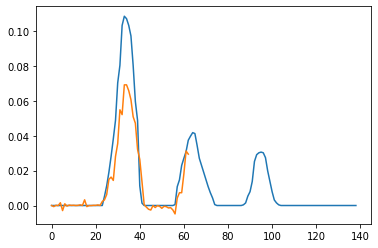

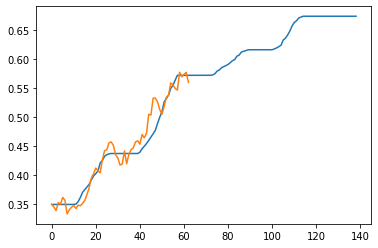

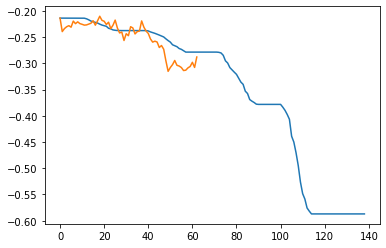

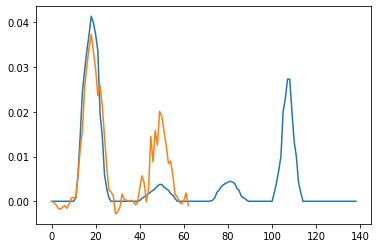

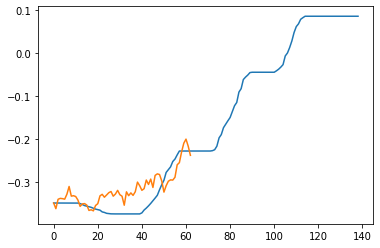

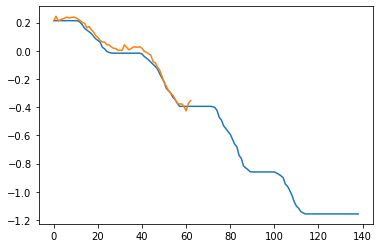

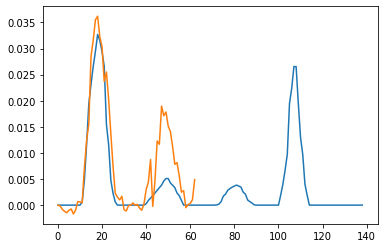

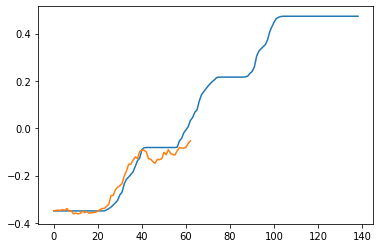

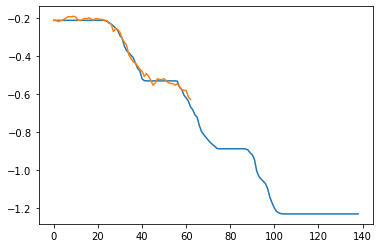

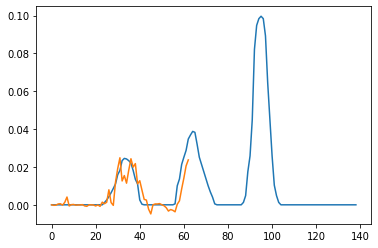

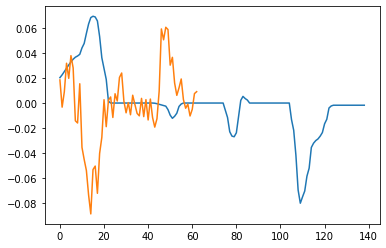

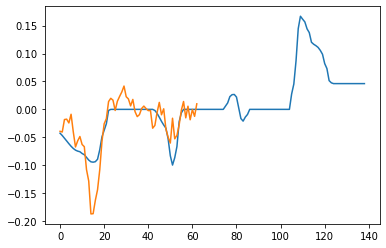

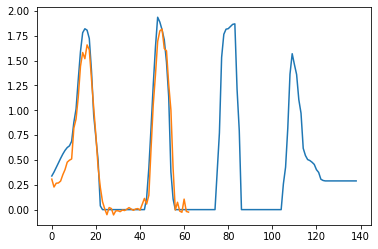

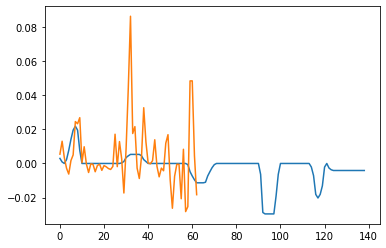

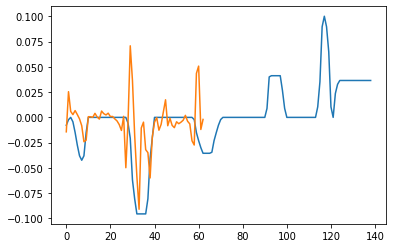

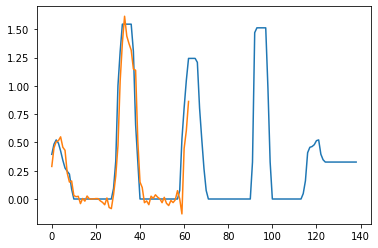

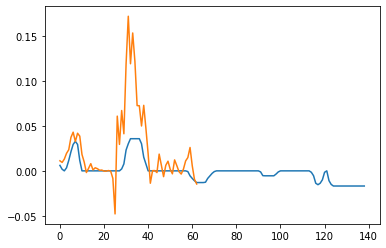

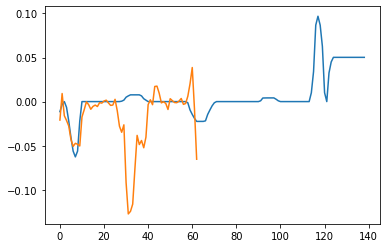

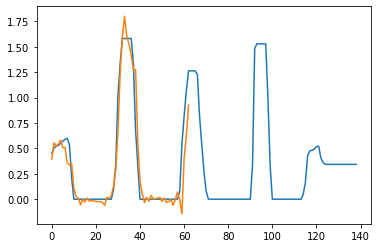

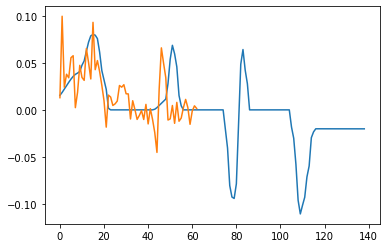

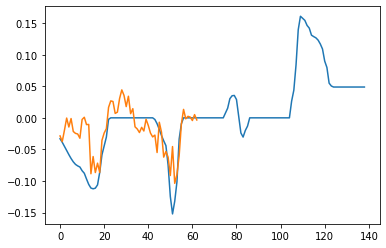

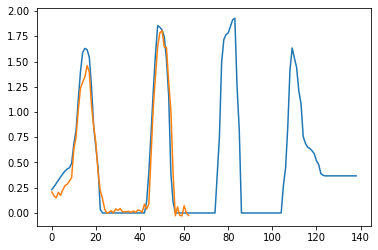

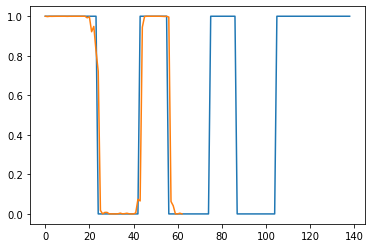

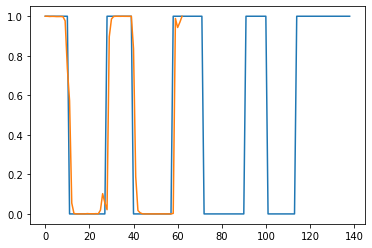

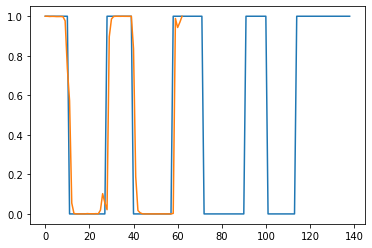

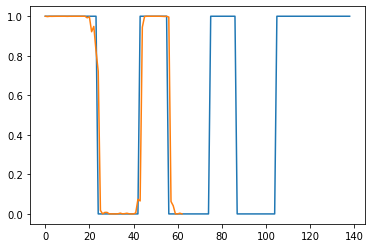

In [343]:
for idx in range(Path_dim):
    plt.plot(Ytr[:,0,idx])
    plt.plot(Path[:,0,idx])
    plt.show()

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Test scene</h1>

AttributeError: 'list' object has no attribute 'view'

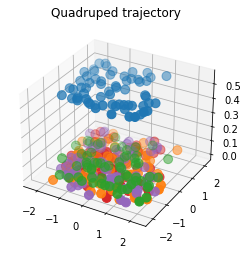

In [344]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Quadruped trajectory')
tmp=Ysample.cpu().detach()
ax.scatter(tmp[-1,:,0], tmp[-1,:,1], tmp[-1,:,2], s=80)
ax.scatter(tmp[-1,:,12], tmp[-1,:,13], tmp[-1,:,14], s=80)
ax.scatter(tmp[-1,:,15], tmp[-1,:,16], tmp[-1,:,17], s=80)
ax.scatter(tmp[-1,:,18], tmp[-1,:,19], tmp[-1,:,20], s=80)
ax.scatter(tmp[-1,:,21], tmp[-1,:,22], tmp[-1,:,23], s=80)

tmp=hypothesis.view(1,-1,40).cpu().detach()
ax.scatter(tmp[:,:,0], tmp[:,:,1], tmp[:,:,2], edgecolor='black')
ax.scatter(tmp[:,:,12], tmp[:,:,13], tmp[:,:,14], edgecolor='black')
ax.scatter(tmp[:,:,15], tmp[:,:,16], tmp[:,:,17], edgecolor='black')
ax.scatter(tmp[:,:,18], tmp[:,:,19], tmp[:,:,20], edgecolor='black')
ax.scatter(tmp[:,:,21], tmp[:,:,22], tmp[:,:,23], edgecolor='black')


807


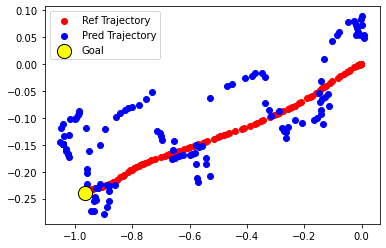

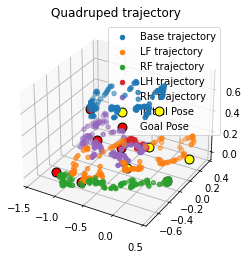

RuntimeError: Requested MovieWriter (ffmpeg) not available

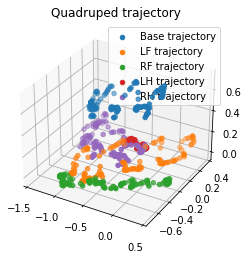

In [347]:
# Target goal
params = torch.load(CodePath+"/model/DeepQMP.tar", map_location = "cpu")
Estimator.load_state_dict(params['model_state_dict'])
Estimator.eval()
motion = Paths_test
index = randint(0, NUMval)
# index=1186
num=index
print(index)

States = Paths_test[num,:,:].view(1,-1,Path_dim)
Goals = Paths_test[num,-1,0:6].view(1,-1,6).repeat(1, Paths_test.shape[1], 1)
XnG = torch.cat([States, Goals],dim=2).type(Tensor)
motion,_ = Estimator(XnG, GenHnC(batch_size=140))
motion = motion.view(1,-1, Path_dim).cpu().detach()
index=0

fig = plt.figure()
plt.scatter(Paths_test[num,:,0], Paths_test[num,:,1], label='Ref Trajectory', color='red')
plt.scatter(motion[index,:,0], motion[index,:,1], label='Pred Trajectory', color='blue')
plt.scatter(Paths_test[num,-1,0], Paths_test[num,-1,1], label='Goal', color='yellow', edgecolor='black', s=200)
plt.legend()
plt.show()

# Plot trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Quadruped trajectory')
body=ax.scatter(motion[index,:,0], motion[index,:,1], motion[index,:,2], label='Base trajectory')
LF=ax.scatter(motion[index,:,12], motion[index,:,13], motion[index,:,14], label='LF trajectory')
RF=ax.scatter(motion[index,:,15], motion[index,:,16], motion[index,:,17], label='RF trajectory')
LH=ax.scatter(motion[index,:,18], motion[index,:,19], motion[index,:,20], label='LH trajectory')
RH=ax.scatter(motion[index,:,21], motion[index,:,22], motion[index,:,23], label='RH trajectory')

body=ax.scatter(Paths_test[num,0,0], Paths_test[num,0,1], Paths_test[num,0,2], label='Initial Pose', color='yellow', edgecolor='black', s=80)
LF=ax.scatter(Paths_test[num,0,12], Paths_test[num,0,13], Paths_test[num,0,14], color='yellow', edgecolor='black', s=80)
RF=ax.scatter(Paths_test[num,0,15], Paths_test[num,0,16], Paths_test[num,0,17], color='yellow', edgecolor='black', s=80)
LH=ax.scatter(Paths_test[num,0,18], Paths_test[num,0,19], Paths_test[num,0,20], color='yellow', edgecolor='black', s=80)
RH=ax.scatter(Paths_test[num,0,21], Paths_test[num,0,22], Paths_test[num,0,23], color='yellow', edgecolor='black', s=80)

body=ax.scatter(Paths_test[num,-1,0], Paths_test[num,-1,1], Paths_test[num,-1,2], label='Goal Pose', color='red', edgecolor='black', s=80)
LF=ax.scatter(Paths_test[num,-1,12], Paths_test[num,-1,13], Paths_test[num,-1,14], color='red', edgecolor='black', s=80)
RF=ax.scatter(Paths_test[num,-1,15], Paths_test[num,-1,16], Paths_test[num,-1,17], color='red', edgecolor='black', s=80)
LH=ax.scatter(Paths_test[num,-1,18], Paths_test[num,-1,19], Paths_test[num,-1,20], color='red', edgecolor='black', s=80)
RH=ax.scatter(Paths_test[num,-1,21], Paths_test[num,-1,22], Paths_test[num,-1,23], color='red', edgecolor='black', s=80)
ax.legend()
plt.show()

# Animation
speed=5
t = np.array([np.ones(speed)*i for i in range(140//speed)]).flatten()
df_body = pd.DataFrame({"time": t ,"x" : motion[index,:,0], "y" : motion[index,:,1], "z" : motion[index,:,2]})
df_LF = pd.DataFrame({"time": t ,"x" : motion[index,:,12], "y" : motion[index,:,13], "z" : motion[index,:,14]})
df_RF = pd.DataFrame({"time": t ,"x" : motion[index,:,15], "y" : motion[index,:,16], "z" : motion[index,:,17]})
df_LH = pd.DataFrame({"time": t ,"x" : motion[index,:,18], "y" : motion[index,:,19], "z" : motion[index,:,20]})
df_RH = pd.DataFrame({"time": t ,"x" : motion[index,:,21], "y" : motion[index,:,22], "z" : motion[index,:,23]})

def update_graph(num):
  # Body
  data=df_body[df_body['time']==num]
  body._offsets3d = (data.x, data.y, data.z)
  # LF
  data=df_LF[df_LF['time']==num]
  LF._offsets3d = (data.x, data.y, data.z)
  # RF
  data=df_RF[df_RF['time']==num]
  RF._offsets3d = (data.x, data.y, data.z)
  # LH
  data=df_LH[df_LH['time']==num]
  LH._offsets3d = (data.x, data.y, data.z)
  # RH
  data=df_RH[df_RH['time']==num]
  RH._offsets3d = (data.x, data.y, data.z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Quadruped trajectory')
body=ax.scatter(motion[index,:,0], motion[index,:,1], motion[index,:,2], label='Base trajectory')
LF=ax.scatter(motion[index,:,12], motion[index,:,13], motion[index,:,14], label='LF trajectory')
RF=ax.scatter(motion[index,:,15], motion[index,:,16], motion[index,:,17], label='RF trajectory')
LH=ax.scatter(motion[index,:,18], motion[index,:,19], motion[index,:,20], label='LH trajectory')
RH=ax.scatter(motion[index,:,21], motion[index,:,22], motion[index,:,23], label='RH trajectory')
ax.legend()

ani = animation.FuncAnimation(fig, update_graph, 140//speed, interval=1000, blit=False)
rc('animation', html='html5')

ani

In [52]:
# Export regenerated motion & goal
for idx in range(MaxSampleNum):
  motion[:,idx,-4]  = cutoff(motion[:,idx,-4]) 
  motion[:,idx,-3]  = cutoff(motion[:,idx,-3]) 
  motion[:,idx,-2]  = cutoff(motion[:,idx,-2]) 
  motion[:,idx,-1]  = cutoff(motion[:,idx,-1])
   
GenMotion = torch.cat([motion, Goals],dim=2).type(Tensor)
OriMotion = torch.cat([Paths_test[num].view(1,-1,Path_dim), Goals],dim=2).type(Tensor)
np.save(CodePath+'/data/GenMotion',GenMotion.cpu())
np.save(CodePath+'/data/OriMotion',OriMotion.cpu())

/home/mrjohd/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
motion_data = np.load(CodePath+'/data/GenMotion.npy')[0]
motion_data[:,-10:-6]

/home/mrjohd/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


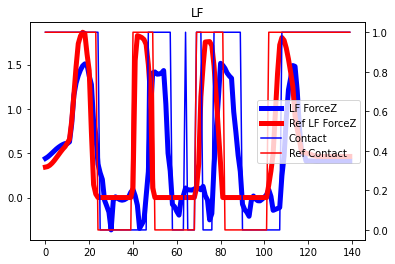

/home/mrjohd/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


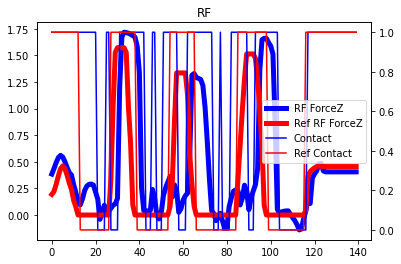

/home/mrjohd/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


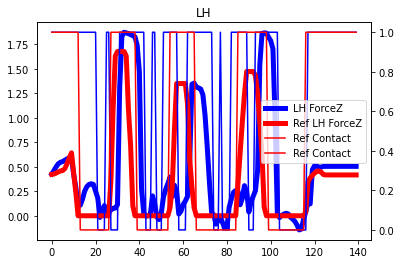

/home/mrjohd/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


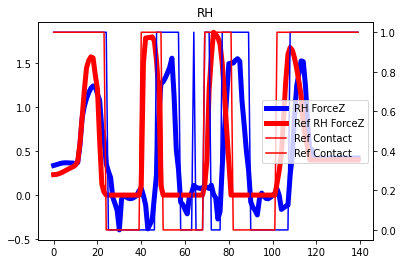

In [85]:
# Contact information
idx=index
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
force,=ax1.plot(motion[0,:,-14], label='LF ForceZ', color='b', linewidth=5)
force2,=ax1.plot(Paths_test[idx,:,-14], label='Ref LF ForceZ', color='r', linewidth=5)
# contact,=ax2.plot(cutoff(torch.sigmoid(motion[0,:,-4])), label='Contact', color='b')
contact,=ax2.plot(cutoff(motion[0,:,-4]), label='Contact', color='b')
contact2,=ax2.plot(Paths_test[idx,:,-4], label='Ref Contact', color='r')
graphs=[force, force2, contact, contact2]
ax2.legend(graphs, [curve.get_label() for curve in graphs])
plt.title("LF")
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
force,=ax1.plot(motion[0,:,-11], label='RF ForceZ', color='b', linewidth=5)
force2,=ax1.plot(Paths_test[idx,:,-11], label='Ref RF ForceZ', color='r', linewidth=5)
# contact,=ax2.plot(cutoff(torch.sigmoid(motion[0,:,-3])), label='Contact', color='b')
contact,=ax2.plot(cutoff(motion[0,:,-3]), label='Contact', color='b')
contact2,=ax2.plot(Paths_test[idx,:,-3], label='Ref Contact', color='r')
graphs=[force, force2, contact, contact2]
ax2.legend(graphs, [curve.get_label() for curve in graphs])
plt.title("RF")
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
force,=ax1.plot(motion[0,:,-8], label='LH ForceZ', color='b', linewidth=5)
force2,=ax1.plot(Paths_test[idx,:,-8], label='Ref LH ForceZ', color='r', linewidth=5)
contact,=ax2.plot(cutoff(motion[0,:,-2]), label='Contact', color='b')
# contact,=ax2.plot(cutoff(torch.sigmoid(motion[0,:,-2])), label='Contact', color='b')
contact,=ax2.plot(Paths_test[idx,:,-2], label='Ref Contact', color='r')
graphs=[force, force2, contact, contact2]
ax2.legend(graphs, [curve.get_label() for curve in graphs])
plt.title("LH")
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
force,=ax1.plot(motion[0,:,-5], label='RH ForceZ', color='b', linewidth=5)
force2,=ax1.plot(Paths_test[idx,:,-5], label='Ref RH ForceZ', color='r', linewidth=5)
contact,=ax2.plot(cutoff(motion[0,:,-1]), label='Contact', color='b')
# contact,=ax2.plot(cutoff(torch.sigmoid(motion[0,:,-1])), label='Contact', color='b')
contact,=ax2.plot(Paths_test[idx,:,-1], label='Ref Contact', color='r')
graphs=[force, force2, contact, contact2]
ax2.legend(graphs, [curve.get_label() for curve in graphs])
plt.title("RH")
plt.show()

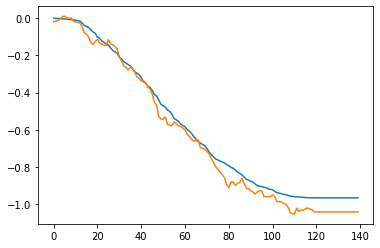

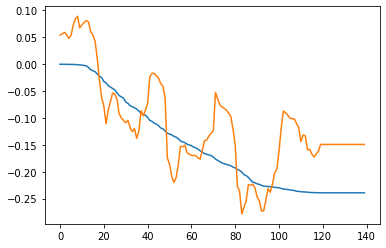

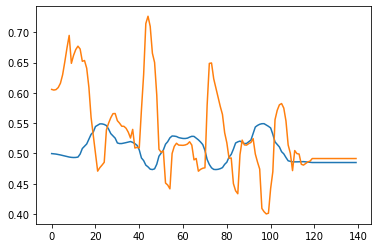

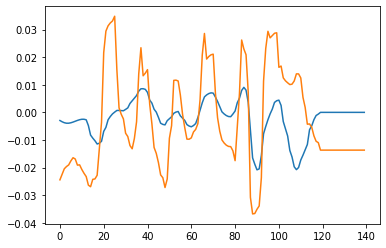

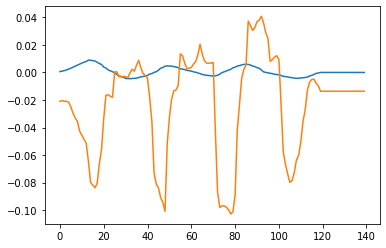

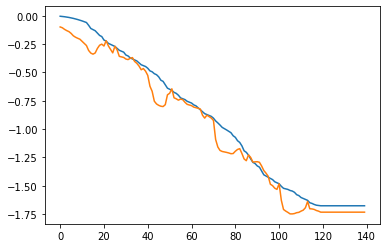

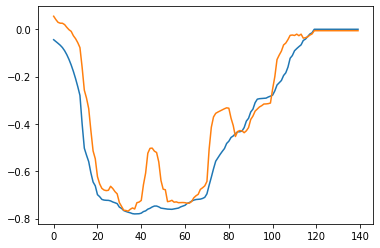

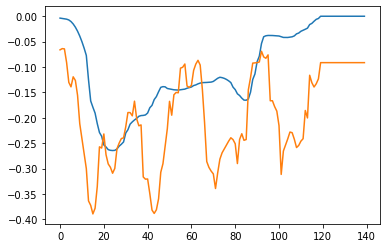

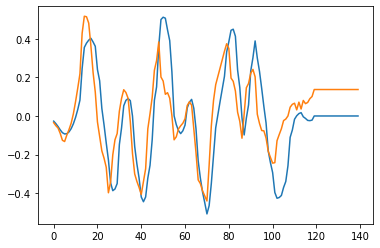

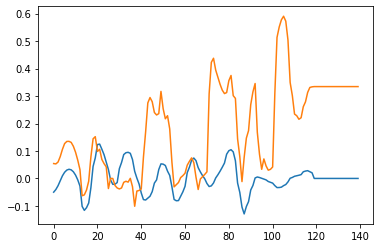

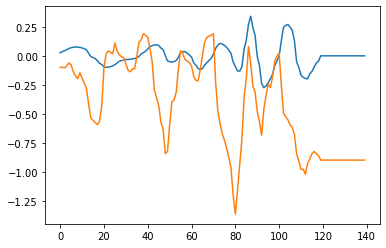

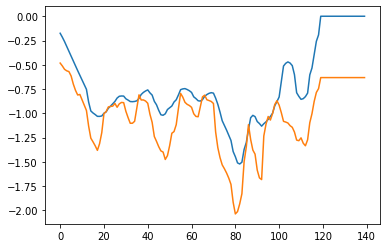

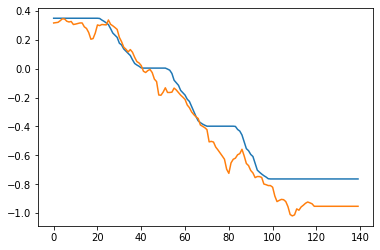

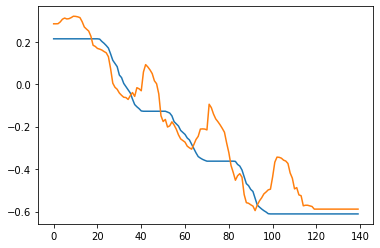

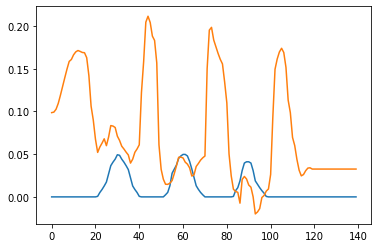

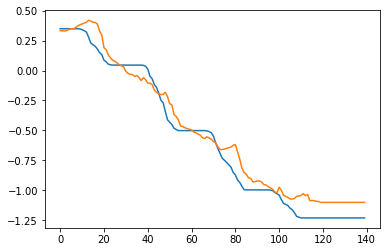

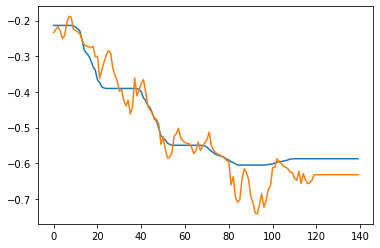

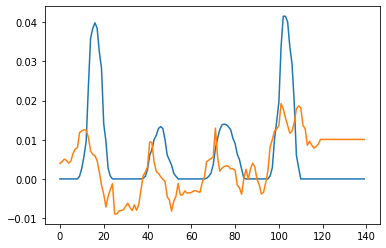

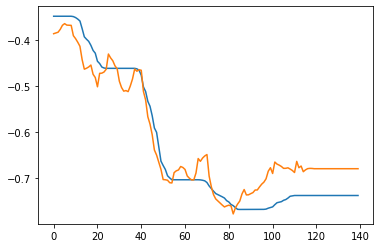

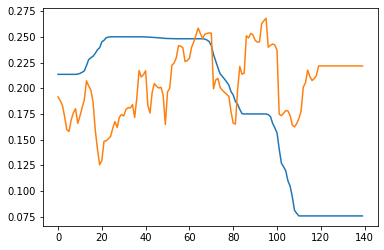

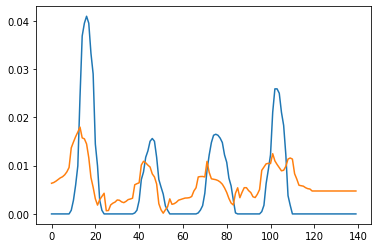

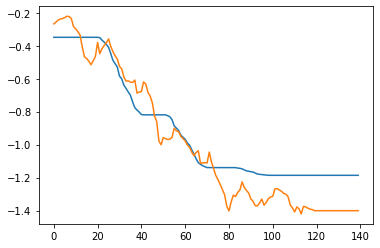

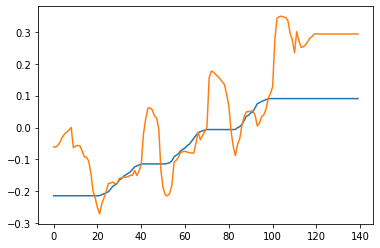

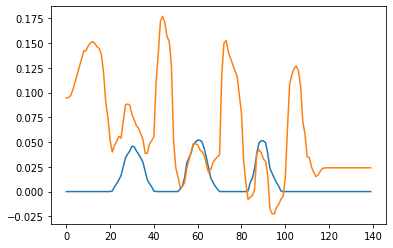

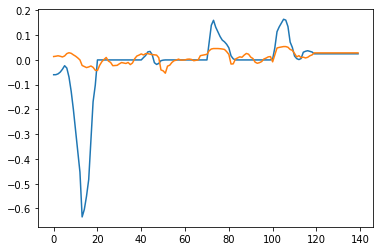

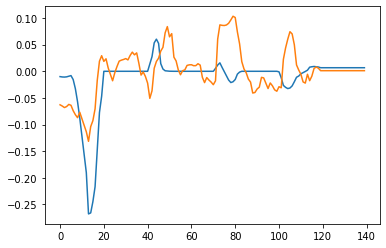

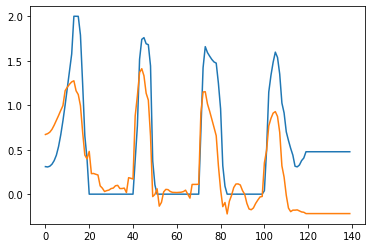

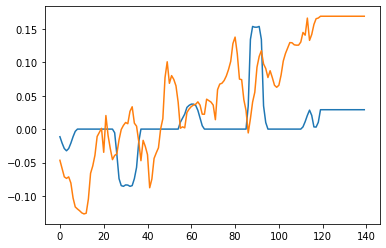

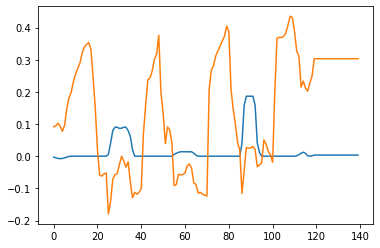

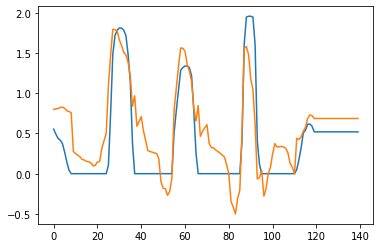

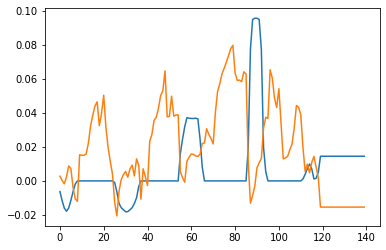

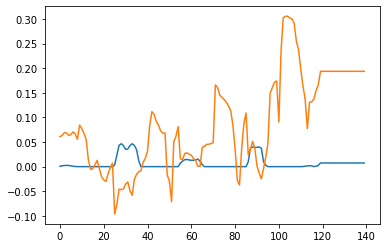

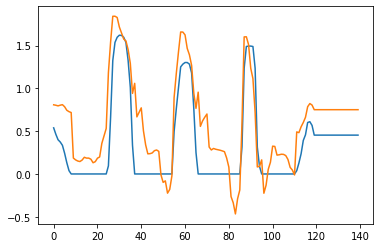

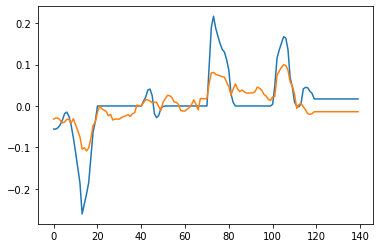

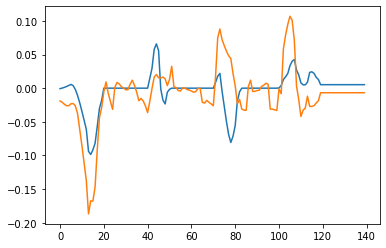

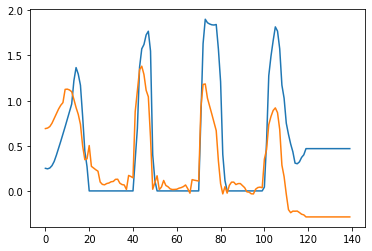

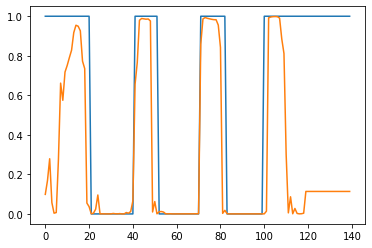

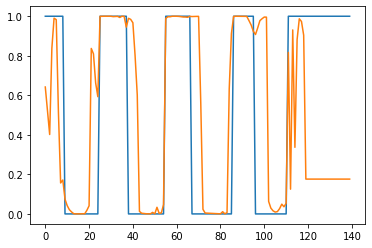

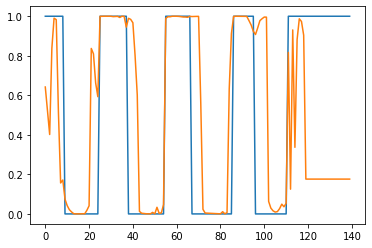

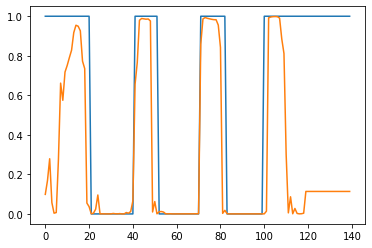

In [348]:
for idx in range(Path_dim):
  plt.plot(Paths_test[num,:,idx])
  plt.plot(motion[0,:,idx])
  plt.show()

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Test Planning</h1>

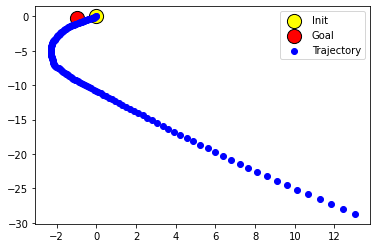

1113 ms


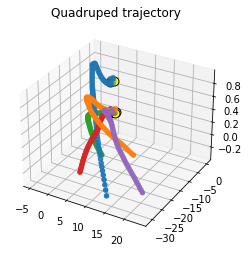

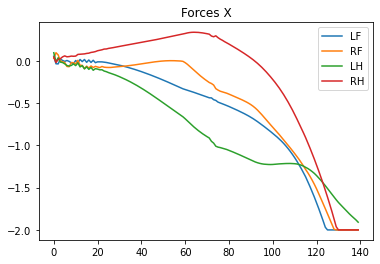

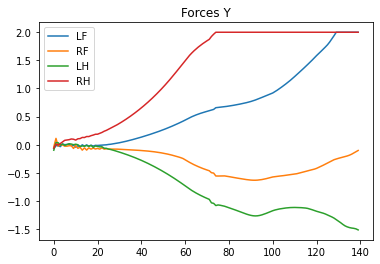

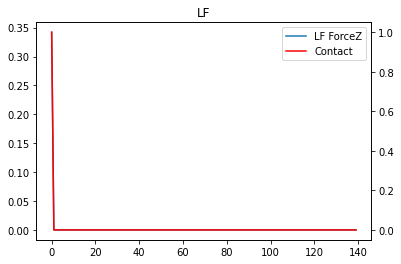

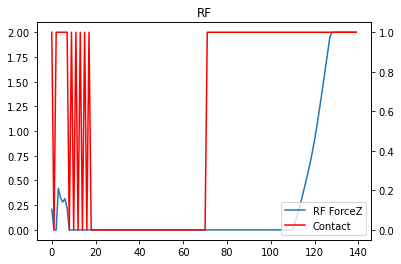

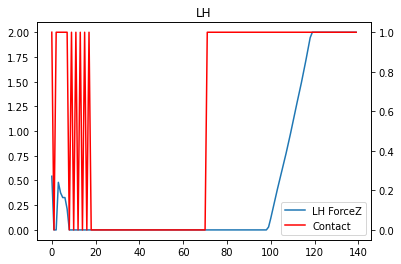

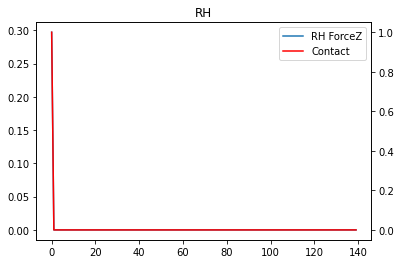

RuntimeError: Requested MovieWriter (ffmpeg) not available

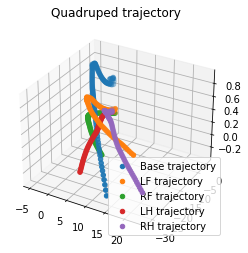

In [349]:
# Test plannning
params = torch.load(CodePath+"/model/DeepQMP.tar", map_location = "cpu")
Estimator.load_state_dict(params['model_state_dict'])
Estimator.eval()

seq_size=5
Init=Paths[0,0,:].view(1,-1,Path_dim).repeat(seq_size,1,1)
Goal = Paths_test[num,-1,0:6].view(1,-1,6).repeat(seq_size,1,1)

State = Variable(Init).type(Tensor).cpu()
Path = Init[0,0,:].view(1,1,Path_dim)
Queue = cp.deepcopy(Init)

iter=0
MAX_iter=MaxSampleNum-1
MaxForces=200
HnC = GenHnC(batch_size=1,requires_grad=False)
ts=int(round(time.time() * 1000))
while (L2_loss(Queue[-1,:,:6], Goal[0]) > 0.01) and (iter<MAX_iter):
  # Clear ipython output
  clear_output(wait=True)

  # Generate next state
  XnG = torch.cat([Queue, Goal],dim=2).type(Tensor)
  State, HnC = Estimator(XnG, HnC)

  # Calculate contact
  State[:,-4:] = cutoff(State[:,-4:])
  # Revise negative forces
  for dom in zDomain:
    if State[:,dom] < 0:
      State[:,dom] = 0
  for dom in range(-16,-4):
    if abs(State[:,dom]) > MaxForces/Scaler:
      State[:,dom] = torch.sign(State[:,dom])*MaxForces/Scaler
    
  if State[:,-4] == 1:
    State[:,-26]=0
  else:
    State[:,-14]=0
    
  if State[:,-3] == 1:
    State[:,-23]=0
  else:
    State[:,-11]=0
    
  if State[:,-2] == 1:
    State[:,-20]=0
  else:
    State[:,-8]=0
    
  if State[:,-1] == 1:
    State[:,-17]=0
  else:
    State[:,-5]=0
    
  # Revise yaw
  if abs(State[0,5]) > math.pi:
      State[0,5] = torch.sign(State[0,5])*math.pi
      # while abs(State[0,5]) > math.pi:
      #     State[0,5] = torch.sign(State[0,5])*(abs(State[0,5]-math.pi))

  # Store states to the path
  State = State.view(1,1,Path_dim).cpu()
  Path = torch.cat([Path, State], dim=1)
  # Update queue
  for i in range(seq_size-1):
    Queue[i,:,:] = Queue[i+1,:,:]
  Queue[-1,:,:] = Variable(State).type(Tensor).cpu()
  iter=iter+1
  # print(L2_loss(State[:,:,:6], Goal))

Path=Path.detach()
plt.scatter(Init[0,:,0], Init[0,:,1], label='Init',s=200, color='yellow', edgecolor='black')
plt.scatter(Goal[0,:,0], Goal[0,:,1], label='Goal', color='red', s=200, edgecolor='black')
plt.scatter(Path[:,:,0], Path[:,:,1], label='Trajectory', color='blue')
plt.legend()
plt.show()

tf=int(round(time.time() * 1000))
print(tf-ts,'ms')

# Plot trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Quadruped trajectory')
body=ax.scatter(Paths_test[num,0,0], Paths_test[num,0,1], Paths_test[num,0,2], label='Initial Pose', color='yellow', edgecolor='black', s=80)
LF=ax.scatter(Paths_test[num,0,12], Paths_test[num,0,13], Paths_test[num,0,14], color='yellow', edgecolor='black', s=80)
RF=ax.scatter(Paths_test[num,0,15], Paths_test[num,0,16], Paths_test[num,0,17], color='yellow', edgecolor='black', s=80)
LH=ax.scatter(Paths_test[num,0,18], Paths_test[num,0,19], Paths_test[num,0,20], color='yellow', edgecolor='black', s=80)
RH=ax.scatter(Paths_test[num,0,21], Paths_test[num,0,22], Paths_test[num,0,23], color='yellow', edgecolor='black', s=80)

body=ax.scatter(Paths_test[num,-1,0], Paths_test[num,-1,1], Paths_test[num,-1,2], label='Goal Pose', color='red', edgecolor='black', s=80)
LF=ax.scatter(Paths_test[num,-1,12], Paths_test[num,-1,13], Paths_test[num,-1,14], color='red', edgecolor='black', s=80)
RF=ax.scatter(Paths_test[num,-1,15], Paths_test[num,-1,16], Paths_test[num,-1,17], color='red', edgecolor='black', s=80)
LH=ax.scatter(Paths_test[num,-1,18], Paths_test[num,-1,19], Paths_test[num,-1,20], color='red', edgecolor='black', s=80)
RH=ax.scatter(Paths_test[num,-1,21], Paths_test[num,-1,22], Paths_test[num,-1,23], color='red', edgecolor='black', s=80)

body=ax.scatter(Path[0,:,0], Path[0,:,1], Path[0,:,2], label='Base trajectory')
LF=ax.scatter(Path[0,:,12], Path[0,:,13], Path[0,:,14], label='LF trajectory')
RF=ax.scatter(Path[0,:,15], Path[0,:,16], Path[0,:,17], label='RF trajectory')
LH=ax.scatter(Path[0,:,18], Path[0,:,19], Path[0,:,20], label='LH trajectory')
RH=ax.scatter(Path[0,:,21], Path[0,:,22], Path[0,:,23], label='RH trajectory')

fig = plt.figure()
plt.title('Forces X')
plt.plot(Path[0,:,-16], label='LF')
plt.plot(Path[0,:,-13], label='RF')
plt.plot(Path[0,:,-10], label='LH')
plt.plot(Path[0,:,-7], label='RH')
plt.legend()
plt.show()

plt.title('Forces Y')
plt.plot(Path[0,:,-15], label='LF')
plt.plot(Path[0,:,-12], label='RF')
plt.plot(Path[0,:,-9], label='LH')
plt.plot(Path[0,:,-6], label='RH')
plt.legend()
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
force,=ax1.plot(Path[0,:,-14], label='LF ForceZ')
contact,=ax2.plot(Path[0,:,-4], label='Contact', color='r')
graphs=[force, contact]
ax2.legend(graphs, [curve.get_label() for curve in graphs])
plt.title("LF")
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
force,=ax1.plot(Path[0,:,-11], label='RF ForceZ')
contact,=ax2.plot(Path[0,:,-3], label='Contact', color='r')
graphs=[force, contact]
ax2.legend(graphs, [curve.get_label() for curve in graphs])
plt.title("RF")
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
force,=ax1.plot(Path[0,:,-8], label='LH ForceZ')
contact,=ax2.plot(Path[0,:,-2], label='Contact', color='r')
graphs=[force, contact]
ax2.legend(graphs, [curve.get_label() for curve in graphs])
plt.title("LH")
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
force,=ax1.plot(Path[0,:,-5], label='RH ForceZ')
contact,=ax2.plot(Path[0,:,-1], label='Contact', color='r')
graphs=[force, contact]
ax2.legend(graphs, [curve.get_label() for curve in graphs])
plt.title("RH")
plt.show()

# Animation
speed=5
t = np.array([np.ones(speed)*i for i in range(140//speed)]).flatten()
df_body = pd.DataFrame({"time": t ,"x" : Path[index,:,0], "y" : Path[index,:,1], "z" : Path[index,:,2]})
df_LF = pd.DataFrame({"time": t ,"x" : Path[index,:,12], "y" : Path[index,:,13], "z" : Path[index,:,14]})
df_RF = pd.DataFrame({"time": t ,"x" : Path[index,:,15], "y" : Path[index,:,16], "z" : Path[index,:,17]})
df_LH = pd.DataFrame({"time": t ,"x" : Path[index,:,18], "y" : Path[index,:,19], "z" : Path[index,:,20]})
df_RH = pd.DataFrame({"time": t ,"x" : Path[index,:,21], "y" : Path[index,:,22], "z" : Path[index,:,23]})

def update_graph(num):
  # Body
  data=df_body[df_body['time']==num]
  body._offsets3d = (data.x, data.y, data.z)
  # LF
  data=df_LF[df_LF['time']==num]
  LF._offsets3d = (data.x, data.y, data.z)
  # RF
  data=df_RF[df_RF['time']==num]
  RF._offsets3d = (data.x, data.y, data.z)
  # LH
  data=df_LH[df_LH['time']==num]
  LH._offsets3d = (data.x, data.y, data.z)
  # RH
  data=df_RH[df_RH['time']==num]
  RH._offsets3d = (data.x, data.y, data.z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Quadruped trajectory')
body=ax.scatter(Path[0,:,0], Path[0,:,1], Path[0,:,2], label='Base trajectory')
LF=ax.scatter(Path[0,:,12], Path[0,:,13], Path[0,:,14], label='LF trajectory')
RF=ax.scatter(Path[0,:,15], Path[0,:,16], Path[0,:,17], label='RF trajectory')
LH=ax.scatter(Path[0,:,18], Path[0,:,19], Path[0,:,20], label='LH trajectory')
RH=ax.scatter(Path[0,:,21], Path[0,:,22], Path[0,:,23], label='RH trajectory')
ax.legend()

ani = animation.FuncAnimation(fig, update_graph, 140//speed, interval=1000, blit=False)
rc('animation', html='html5')

ani


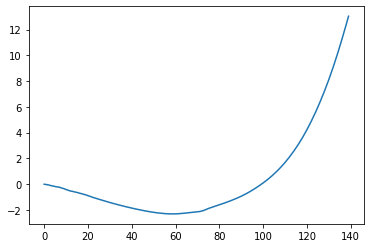

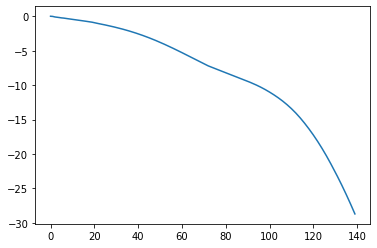

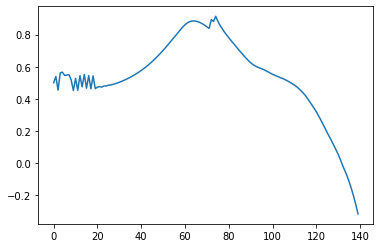

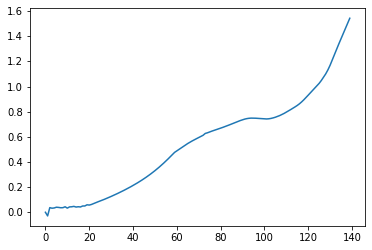

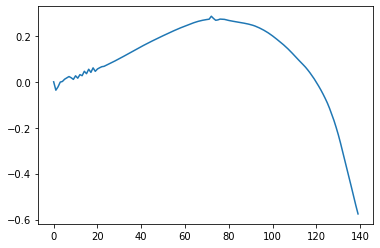

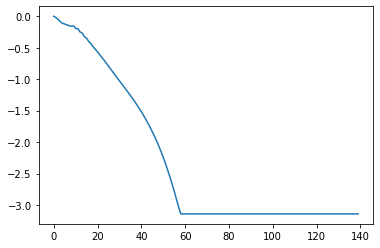

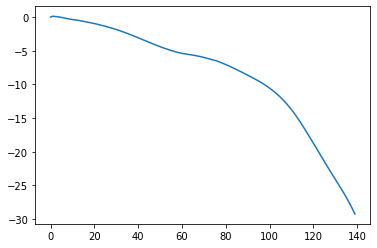

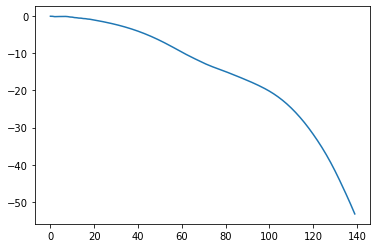

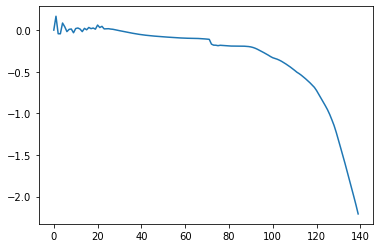

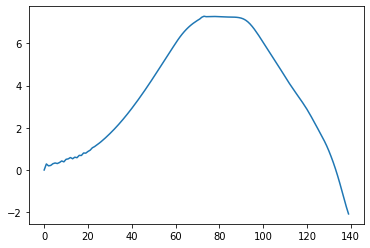

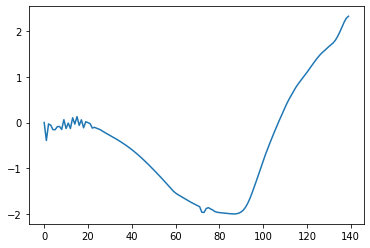

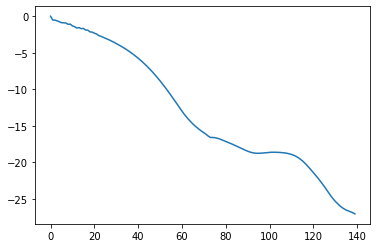

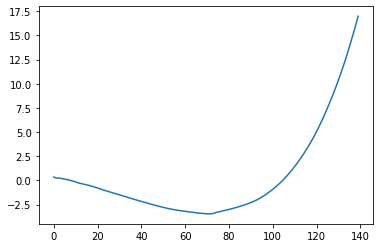

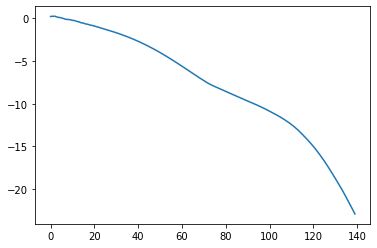

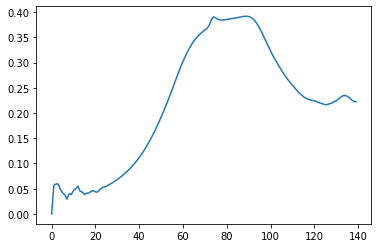

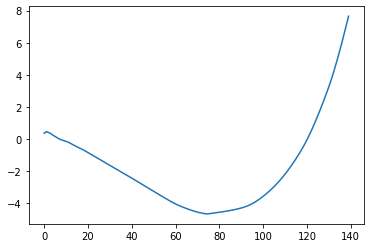

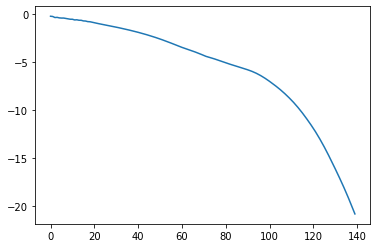

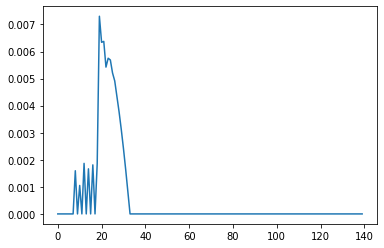

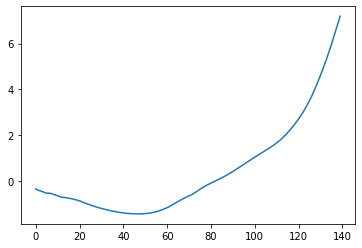

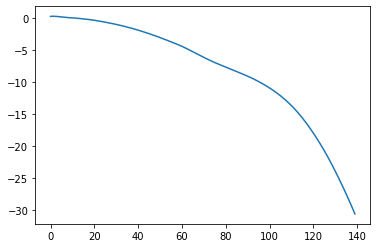

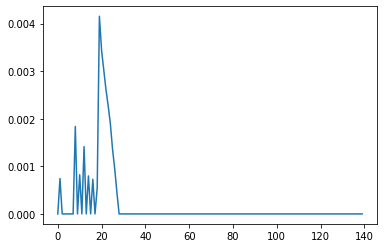

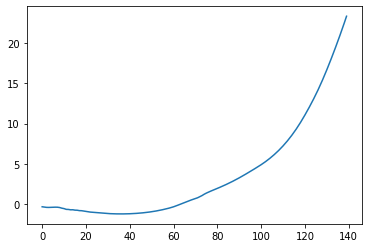

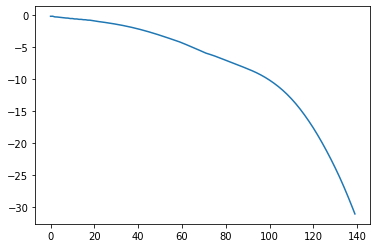

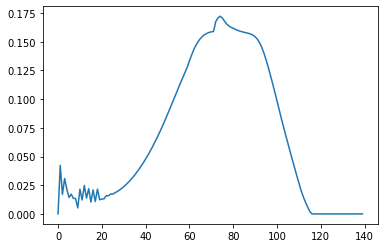

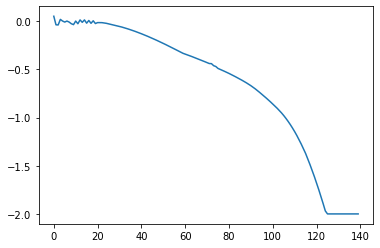

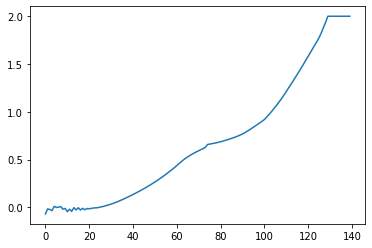

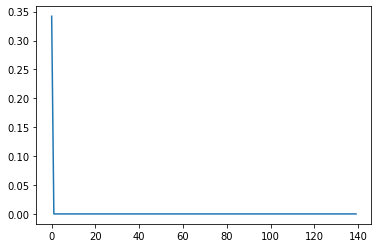

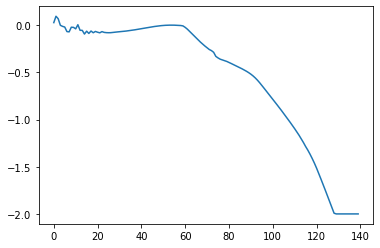

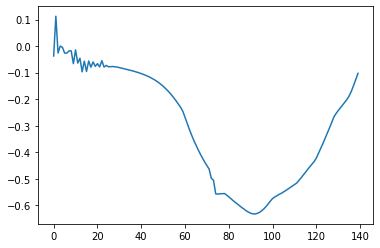

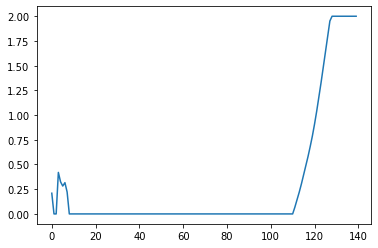

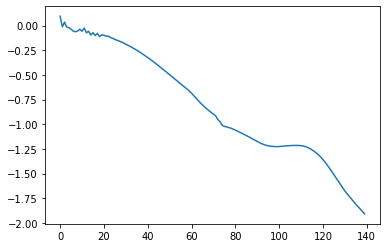

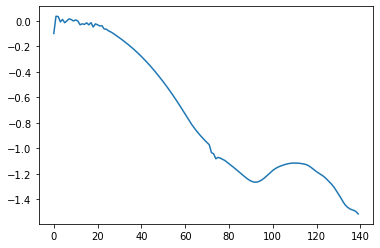

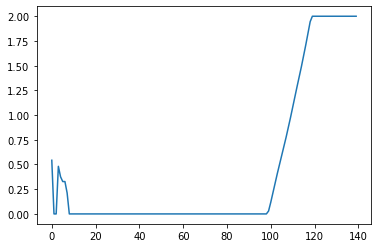

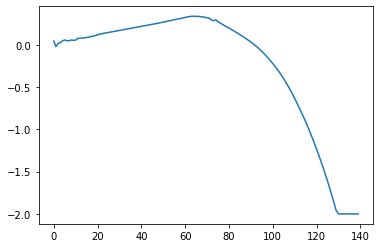

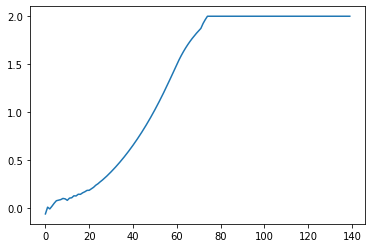

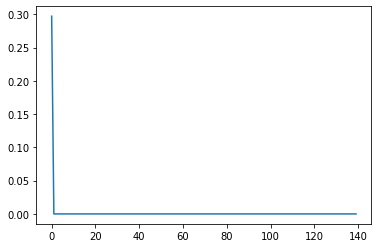

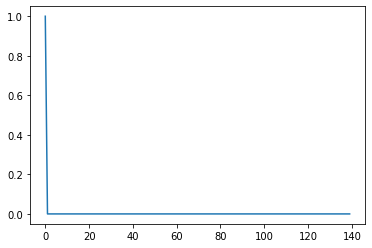

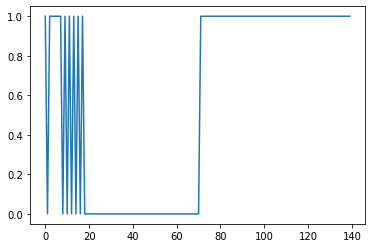

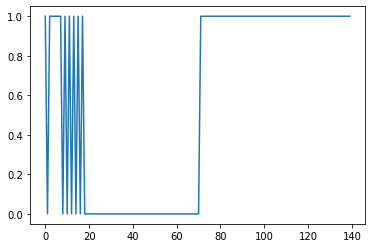

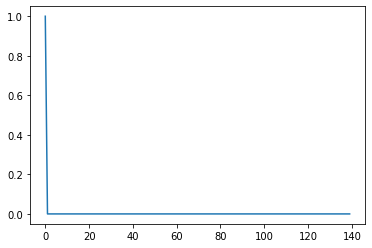

In [350]:
for idx in range(Path_dim):
  plt.plot(Path[0,:,idx])
  plt.show()

In [ ]:
# Test plannning
params = torch.load("/content/drive/My Drive/Colab Notebooks/model/DeepQMP.tar", map_location = "cpu")
Estimator.load_state_dict(params['model_state_dict'])
Estimator.eval()

# seq_size=3
Init=Paths[0,0,:].view(1,-1,Path_dim).repeat(seq_size,1,1)
Goal = Paths_test[num,-1,0:6].view(1,-1,6).repeat(seq_size,1,1)

State = Variable(Init).type(Tensor).cpu()
Path = Init[0,0,:].view(1,1,Path_dim)
Queue = Variable(Init).type(Tensor).cpu()

In [ ]:
iter=0
MAX_iter=MaxSampleNum-1
MaxForces=200
HnC = GenHnC(batch_size=1,requires_grad=False)
ts=int(round(time.time() * 1000))
# Clear ipython output
clear_output(wait=True)

# Generate next state
XnG = torch.cat([Queue, Goal],dim=2).type(Tensor)
State, HnC = Estimator(XnG, HnC)

# Calculate contact
for contact in range(-4,0):
  State[:,contact] = cutoff(State[:,contact])
  # State[:,:,contact] = cutoff(torch.sigmoid(State[:,:,contact]))
# Revise negative forces
for dom in domain:
  if State[:,dom] < 0:
    State[:,dom] = 0
for dom in range(-16,-4):
  if abs(State[:,dom]) > MaxForces/Scaler:
    State[:,dom] = torch.sign(State[:,dom])*MaxForces/Scaler

# Store states to the path
State = State.view(1,1,Path_dim).cpu()
Path = torch.cat([Path, State], dim=1)
# Update queue
for i in range(seq_size-1):
  Queue[i,:,:] = Queue[i+1,:,:]
Queue[-1,:,:] = Variable(State).type(Tensor).cpu()
iter=iter+1
# print(L2_loss(State[:,:,:6], Goal))

Path=Path.detach()
plt.scatter(Init[0,:,0], Init[0,:,1], label='Init',s=200, color='yellow', edgecolor='black')
plt.scatter(Goal[0,:,0], Goal[0,:,1], label='Goal', color='red', s=200, edgecolor='black')
plt.scatter(Path[:,:,0], Path[:,:,1], label='Trajectory', color='blue')
plt.legend()
plt.show()

tf=int(round(time.time() * 1000))
print(tf-ts,'ms')

# Plot trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Quadruped trajectory')
body=ax.scatter(Paths_test[num,0,0], Paths_test[num,0,1], Paths_test[num,0,2], label='Initial Pose', color='yellow', edgecolor='black', s=80)
LF=ax.scatter(Paths_test[num,0,12], Paths_test[num,0,13], Paths_test[num,0,14], color='yellow', edgecolor='black', s=80)
RF=ax.scatter(Paths_test[num,0,15], Paths_test[num,0,16], Paths_test[num,0,17], color='yellow', edgecolor='black', s=80)
LH=ax.scatter(Paths_test[num,0,18], Paths_test[num,0,19], Paths_test[num,0,20], color='yellow', edgecolor='black', s=80)
RH=ax.scatter(Paths_test[num,0,21], Paths_test[num,0,22], Paths_test[num,0,23], color='yellow', edgecolor='black', s=80)

body=ax.scatter(Paths_test[num,-1,0], Paths_test[num,-1,1], Paths_test[num,-1,2], label='Goal Pose', color='red', edgecolor='black', s=80)
LF=ax.scatter(Paths_test[num,-1,12], Paths_test[num,-1,13], Paths_test[num,-1,14], color='red', edgecolor='black', s=80)
RF=ax.scatter(Paths_test[num,-1,15], Paths_test[num,-1,16], Paths_test[num,-1,17], color='red', edgecolor='black', s=80)
LH=ax.scatter(Paths_test[num,-1,18], Paths_test[num,-1,19], Paths_test[num,-1,20], color='red', edgecolor='black', s=80)
RH=ax.scatter(Paths_test[num,-1,21], Paths_test[num,-1,22], Paths_test[num,-1,23], color='red', edgecolor='black', s=80)

body=ax.scatter(Path[0,:,0], Path[0,:,1], Path[0,:,2], label='Base trajectory')
LF=ax.scatter(Path[0,:,12], Path[0,:,13], Path[0,:,14], label='LF trajectory')
RF=ax.scatter(Path[0,:,15], Path[0,:,16], Path[0,:,17], label='RF trajectory')
LH=ax.scatter(Path[0,:,18], Path[0,:,19], Path[0,:,20], label='LH trajectory')
RH=ax.scatter(Path[0,:,21], Path[0,:,22], Path[0,:,23], label='RH trajectory')

In [ ]:
Queue

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Test Metric</h1>

In [ ]:
# Eval
import copy
model = DeepQMP();
model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
params = torch.load("/content/drive/My Drive/Colab Notebooks/model/DeepQMP.tar", map_location = "cpu")
model.load_state_dict(params['model_state_dict'])
model.eval()

err_x = []
err_y = []
err_yaw = []
 
index = np.random.randint(len(Xval[seq_size-1::seq_size,:]))
ts=int(round(time.time() * 1000))
input = Xval_LSTM[:,index,:]

Xo=Xval[seq_size-1::seq_size,:]
hypo,(h1,c1),(h2,c2) = model(input.view(seq_size,-1,input_dim),(hidden_test1, cell_test1),(hidden_test2, cell_test2))
output=copy.deepcopy(Variable(hypo))
output[:,0:2] = hypo[:,0:2]
 
tf=int(round(time.time() * 1000))
print(tf-ts,'ms')
 
plt.title("Arbitrary sample - XY")
# plt.xlim(-22,22);plt.ylim(-22,22)
plt.scatter(Xval_LSTM[:,index,0].cpu(), Xval_LSTM[:,index,1].cpu(),s=500.0, c='y', edgecolors='y', label='XY input')
plt.scatter(Yval_LSTM[:,index,0].cpu(), Yval_LSTM[:,index,1].cpu(),s=200.0, c='r', edgecolors='r', label='XY expected')
plt.scatter(output[:,0].item(), output[:,1].item(),s=100.0, c='b', edgecolors='black', linewidth=5, alpha=0.8 , label='XY predicted')
plt.scatter(Xval_LSTM[0,index,0].cpu(), Xval_LSTM[0,index,1].cpu(),s=700.0, c='m', edgecolors='y', label='XY origin')
plt.scatter(Xval_LSTM[-1,index,0].cpu(), Xval_LSTM[-1,index,1].cpu(),s=700.0, c='g', edgecolors='r', label='XY last')
plt.legend(fontsize='x-large')
plt.show()

In [ ]:
input = Xval[index,:]
 
hidden_test1 = torch.zeros(1, 1, hidden_dim1).to(device)
cell_test1 = torch.zeros(1, 1, hidden_dim1).to(device)
hidden_test2 = torch.zeros(1, 1, hidden_dim2).to(device)
cell_test2 = torch.zeros(1, 1, hidden_dim2).to(device)

Xo=Xval
hypo,(h1,c1),(h2,c2) = model(input.view(1,-1,input_dim),(hidden_test1, cell_test1),(hidden_test2, cell_test2))
output=copy.deepcopy(Variable(hypo))
output[:,0:2] = hypo[:,0:2]
 
plt.title("Arbitrary sample - XY")
# plt.xlim(-22,22);plt.ylim(-22,22)
plt.scatter(Xval[index,0].cpu(), Xval[index,1].cpu(),s=500.0, c='y', edgecolors='y', label='XY origin')
plt.scatter(Yval[index,0].cpu(), Yval[index,1].cpu(),s=300.0, c='r', edgecolors='y', label='XY expected')
plt.scatter(output[:,0].item(), output[:,1].item(),s=100.0, c='b', edgecolors='black', linewidth=5, alpha=0.8 , label='XY predicted')
plt.legend(fontsize='x-large')
plt.show()

In [ ]:
batch_test = 1000
# input = Xte.reshape(input_dim,-1,1)
# input = Xte.reshape(3,-1,1)
input = Xte_LSTM
# input = Xte_ori
hidden_test1 = torch.zeros(1, batch_test, hidden_dim1).to(device)
cell_test1 = torch.zeros(1, batch_test, hidden_dim1).to(device)
hidden_test2 = torch.zeros(1, batch_test, hidden_dim2).to(device)
cell_test2 = torch.zeros(1, batch_test, hidden_dim2).to(device)
hypo,(h1,c1),(h2,c2)  = model(input,(hidden_test1, cell_test1),(hidden_test2, cell_test2))
output=copy.deepcopy(Variable(hypo))
output[:,0:2] = hypo[:,0:2]/scaler + Xte_ori[:,0:2].to(device)
output[:,2] = hypo[:,2] + Xte_ori[:,2].to(device)
# error = (np.square(Yte[:,0:2].numpy() - output[:,0:2].detach().numpy())).mean()
# error       = (np.square(Yte_ori.numpy() - output.detach().numpy())).mean()
error_input = np.sqrt((np.square(Xte_ori[:,0:-2].cpu().numpy() - output.detach().cpu().numpy())).mean())
# error = (np.square(Ytr.numpy() - output.detach().numpy())).mean()
error = (output-Yte_ori).cpu().detach().numpy()
for i in range(len(error)):
        if abs(error[i,2]) > 180:
          error[i,2] = np.sign(error[i,2])*(360-abs(error[i,2]));
error_target = np.sqrt(np.square(error).mean())
# error_input = L2_loss(output,Xte_ori[:,0:-2])

Pred = output.cpu().detach().numpy()
 
# plt.title("Predicted - XY")
# plt.scatter(Pred[:,0], Pred[:,1],s=20.0 , c='c', edgecolors='black')
# plt.show()
# plt.title("Predicted - YAW")
# plt.plot(Pred[:,2],'.', c='c')
# plt.show()
 
num_sam = 5000
plt.title(str(num_sam)+ " samples. vs. Input - XY")
plt.scatter(Xte_LSTM_ori[0,0:num_sam,0].cpu(), Xte_LSTM_ori[1,0:num_sam,0].cpu(),s=50.0, c='y', edgecolors='black')
plt.scatter(Pred[0:num_sam,0], Pred[0:num_sam,1],s=50.0 , c='c', edgecolors='black', alpha=0.8)
plt.show()
plt.title(str(num_sam)+ " samples. vs. Target - XY")
plt.scatter(Yte_LSTM_ori[0,0:num_sam,0].cpu(), Yte_LSTM_ori[1,0:num_sam,0].cpu(),s=50.0 , c='r', edgecolors='black')
plt.scatter(Pred[0:num_sam,0], Pred[0:num_sam,1],s=50.0 , c='c', edgecolors='black', alpha=0.8)
plt.show()

plt.title(str(num_sam)+ " samples. vs. Input - Yaw")
plt.plot(Xte_LSTM_ori[2,0:num_sam,0].cpu(),'.', c='y')
plt.plot(Pred[0:num_sam,2],'.', c='c', alpha=0.8)
plt.show()
plt.title(str(num_sam)+ " samples. vs. Target - Yaw")
plt.plot(Yte_LSTM_ori[2,0:num_sam,0].cpu(),'.', c='r')
plt.plot(Pred[0:num_sam,2],'.', c='c', alpha=0.8)
plt.show()

plt.title(str(num_sam)+ " samples. vs. Input - dx")
Xte_ori=Xte_ori.cpu()
plt.ylim(min(np.min(Pred[0:num_sam,0]-Xte_ori[0:num_sam,0].numpy()),np.min(error[0:num_sam,0])),max(np.max(Pred[0:num_sam,0]-Xte_ori[0:num_sam,0].numpy()),np.max(error[0:num_sam,0])))
plt.plot(Pred[0:num_sam,0]-Xte_ori[0:num_sam,0].numpy(),'.', c='y')
plt.title(str(num_sam)+ " samples. vs. Target - dx")
plt.ylim(min(np.min(Pred[0:num_sam,0]-Xte_ori[0:num_sam,0].numpy()),np.min(error[0:num_sam,0])),max(np.max(Pred[0:num_sam,0]-Xte_ori[0:num_sam,0].numpy()),np.max(error[0:num_sam,0])))
plt.plot(error[0:num_sam,0],'.', c='r')
plt.show()

plt.title(str(num_sam)+ " samples. vs. Input - dy")
plt.ylim(min(np.min(Pred[0:num_sam,1]-Xte_ori[0:num_sam,1].numpy()),np.min(error[0:num_sam,1])),max(np.max(Pred[0:num_sam,1]-Xte_ori[0:num_sam,1].numpy()),np.max(error[0:num_sam,1])))
plt.plot(Pred[0:num_sam,1]-Xte_ori[0:num_sam,1].numpy(),'.', c='y')
plt.title(str(num_sam)+ " samples. vs. Target - dy")
plt.ylim(min(np.min(Pred[0:num_sam,1]-Xte_ori[0:num_sam,1].numpy()),np.min(error[0:num_sam,1])),max(np.max(Pred[0:num_sam,1]-Xte_ori[0:num_sam,1].numpy()),np.max(error[0:num_sam,1])))
plt.plot(error[0:num_sam,1],'.', c='r')
plt.show()

plt.title(str(num_sam)+ " samples. vs. Input - dYaw")
plt.ylim(min(np.min(Pred[0:num_sam,2]-Xte_ori[0:num_sam,2].numpy()),np.min(error[0:num_sam,2])),max(np.max(Pred[0:num_sam,2]-Xte_ori[0:num_sam,2].numpy()),np.max(error[0:num_sam,2])))
plt.plot(Pred[0:num_sam,2]-Xte_ori[0:num_sam,2].numpy(),'.', c='y')
plt.title(str(num_sam)+ " samples. vs. Target - dYaw")
plt.ylim(min(np.min(Pred[0:num_sam,2]-Xte_ori[0:num_sam,2].numpy()),np.min(error[0:num_sam,2])),max(np.max(Pred[0:num_sam,2]-Xte_ori[0:num_sam,2].numpy()),np.max(error[0:num_sam,2])))
plt.plot(error[0:num_sam,2],'.', c='r')
plt.show()

# plt.title(str(num_sam)+ " sample - X")
# plt.plot(Yte_LSTM_ori[0,0:num_sam,0],'.', c='r')
# plt.plot(Pred[0:num_sam,0],'.', c='c', alpha=0.8)
# plt.show()
# plt.title(str(num_sam)+ " sample - Y")
# plt.plot(Yte_LSTM_ori[1,0:num_sam,0],'.', c='r')
# plt.plot(Pred[0:num_sam,1],'.', c='c', alpha=0.8)
# plt.show()
 
Yte_LSTM_ori=Yte_LSTM_ori.cpu()
plt.title("Expected - Predicted - X")
plt.scatter(Yte_LSTM_ori[0,:,0], Pred[:,0], s=20.0 , c='r', edgecolors='black')
plt.show()
 
plt.title("Expected - Predicted - Y")
plt.scatter(Yte_LSTM_ori[1,:,0], Pred[:,1], s=20.0 , c='g', edgecolors='black')
plt.show()
 
plt.title("Expected - Predicted - YAW")
plt.scatter(Yte_LSTM_ori[2,:,0], Pred[:,2], s=20.0 , c='c', edgecolors='black')
plt.show()
 
print("TEST error     : ",error_target)
print("TEST error_in  : ",error_input)
print("TEST dist      : ", np.sqrt((np.square(Yte_ori[:,0:2].cpu().numpy() - output[:,0:2].cpu().detach().numpy())).mean()))
print("TEST dist_in   : ", np.sqrt((np.square(Xte_ori[:,0:2].cpu().numpy() - output[:,0:2].cpu().detach().numpy())).mean()))

print("TEST dyaw      : ", np.sqrt(np.square(error[:,2].mean())))
print("TEST dyaw_in   : ", np.sqrt((np.square(Xte_ori[:,2].cpu().numpy() - output[:,2].cpu().detach().numpy())).mean()))

print("TEST dvel      : ", np.sqrt((np.square(Yte_ori[:,3:6].cpu().numpy() - output[:,3:6].cpu().detach().numpy())).mean()))
print("TEST delv_in   : ", np.sqrt((np.square(Xte_ori[:,3:6].cpu().numpy() - output[:,3:6].cpu().detach().numpy())).mean()))

print("TEST domg      : ", np.sqrt((np.square(Yte_ori[:,6:8].cpu().numpy() - output[:,6:8].cpu().detach().numpy())).mean()))
print("TEST domg_in   : ", np.sqrt((np.square(Xte_ori[:,6:8].cpu().numpy() - output[:,6:8].cpu().detach().numpy())).mean()))

print('TEST input     : ',Xte_LSTM_ori[0:3,index,:].T.cpu().detach().numpy()[0])
print('TEST expected  : ',Yte_LSTM_ori[0:3,index,:].T.cpu().detach().numpy()[0])
print('TEST predict   : ',Pred[index,0:3])

In [ ]:
print("Training data")
plt.title("Training - XY")
plt.scatter(Xtr_LSTM_ori[0,:,:], Xtr_LSTM_ori[1,:,:],s=20.0 , c='r', edgecolors='black')
plt.show()
plt.title("Training - X")
plt.plot(Xtr_LSTM_ori[0,:,:],'.', c='c')
plt.show()
plt.title("Training - Y")
plt.plot(Xtr_LSTM_ori[1,:,:],'.', c='c')
plt.show()
plt.title("Training - YAW")
plt.plot(Xtr_LSTM_ori[2,:,:],'.', c='c')
plt.show()
plt.title("Training - V")
plt.scatter(Xtr_LSTM_ori[3,:,:], Xtr_LSTM_ori[4,:,:],s=20.0 , c='y', edgecolors='black')
plt.show()
plt.title("Training - Vx")
plt.plot(Xtr_ori[:,3],'.', c='g')
plt.show()
plt.title("Training - Vy")
plt.plot(Xtr_ori[:,4],'.', c='g')
plt.show()
plt.title("Training - Vyaw")
plt.plot(Xtr_ori[:,5],'.', c='g')
plt.show()
plt.title("Training - wR")
plt.plot(Xtr_ori[:,6],'.', c='g')
plt.show()
plt.title("Training - wL")
plt.plot(Xtr_ori[:,7],'.', c='g')
plt.show()
plt.title("Training - tR")
plt.plot(Xtr_ori[:,8],'.', c='g')
plt.show()
plt.title("Training - tL")
plt.plot(Xtr_ori[:,9],'.', c='g')
plt.show()

In [ ]:
import requests
from bs4 import BeautifulSoup 
import csv

url='http://www.kobis.or.kr/kobis/business/mast/thea/findTheaterInfoList.do#none'
r=requests.post(url)
soup=BeautifulSoup(r.text, 'html.parser')

path = "/content/drive/My Drive/Colab Notebooks/temp"
with open(r"/content/drive/My Drive/Colab Notebooks/temp/TheaterInfo.csv", "w", newline='') as out:
  theater=csv.writer(out)
  theater.writerow(['City', 'District', 'Code', 'Name', 'NumScreen', 'NumSeats', 'Permanent', 'Registered', 'Licensee', 'OpenDate', 'Run'])

for i in range(1,11):
  page=i
  payload={'pageIndex':page}
  r=requests.post(url, params=payload)
  soup=BeautifulSoup(r.text, "html.parser")
  table=soup.find('table')
  rows=table.find('tbody').find_all('tr')
  
  for j in range(10):
    result=[]
    col=rows[j].find_all('td')
    for item in col:
      result.append(item.text)
    print(result)

    with open(r'/content/drive/My Drive/Colab Notebooks/temp/TheaterInfo.csv', "a",encoding='euc_kr', newline='') as out:
      theater=csv.writer(out)
      theater.writerow(result)
  
  print()